In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
import sportypy
import importlib
import requests
import re
import plotly.express as px
import plotly.graph_objects as go

## Stage 1: Importing, Combining, and Correcting Data

In [2]:
# Import the function to read in the data from the Starter File
import SMT_Data_Starter_2025
importlib.reload(SMT_Data_Starter_2025)
from SMT_Data_Starter_2025 import readDataSubset

game_info_subset = readDataSubset('game_info')
game_info = game_info_subset.to_table().to_pandas()
game_info.loc[67281, 'play_per_game'] = 66.0
game_info = game_info.sort_values(['game_str', 'play_per_game']).reset_index(drop=True)


# Read in the Game Events Data and filter to 1st year
game_events_subset = readDataSubset('game_events')
game_events = game_events_subset.to_table().to_pandas()
game_events['at_bat'] = pd.to_numeric(game_events['at_bat'], errors='coerce')
# removing row with obviously incorrect timestamp
game_events = game_events.drop(182421).reset_index(drop=True)
# game_events = game_events.sort_values(['game_str', 'play_id', 'at_bat']).reset_index(drop=True)

In [3]:
sig_cols = ['game_str','play_per_game','top_bottom_inning','batter','first_baserunner','second_baserunner','third_baserunner']

In [4]:
def play_lookup(df, game, pid):
    return df[(df['game_str']==game)&(df['play_id']==pid)]

In [5]:
at_bat_game_info = list()
for row in range(len(game_info)):
    if row == 0:
        at_bat_game_info.append(1)
    elif game_info.loc[row, 'game_str'] != game_info.loc[row - 1, 'game_str']:
        at_bat_game_info.append(1)
    elif game_info.loc[row, 'batter'] == game_info.loc[row - 1, 'batter']:
        at_bat_game_info.append(at_bat_game_info[row-1])
    else:
        at_bat_game_info.append(at_bat_game_info[row-1] + 1)

game_info['at_bat'] = at_bat_game_info

missing_abs = game_info.groupby('game_str').filter(lambda x: x['at_bat'].isna().any())
missing_no_abs = game_info.groupby('game_str').filter(lambda x: x['at_bat'].notna().all())

print('number of games missing at least one AB:', missing_abs['game_str'].nunique())
print('number of games missing no ABs:', missing_no_abs['game_str'].nunique())

number of games missing at least one AB: 0
number of games missing no ABs: 274


In [6]:
all_merged = game_events.merge(game_info, on = ['game_str', 'play_per_game'], how = 'outer')#[['game_str', 'at_bat_x', 'at_bat_y', 'play_per_game', 'play_id', 'batter']]#.dropna()
all_merged = all_merged.sort_values(['game_str', 'play_id', 'timestamp']).reset_index(drop=True)

In [7]:
def remove_suffixes(df, first_suffix = '_x', second_suffix = '_y'):
    df = df.drop(columns = [col for col in df.columns if first_suffix in col])
    return df.rename(columns = {col: col.replace(second_suffix, '') for col in df.columns})

In [8]:
game_merged = game_events.merge(game_info, on = ['game_str', 'play_per_game'])
game_merged_small = game_merged[['game_str', 'play_id', 'at_bat_x', 'at_bat_y', 'play_per_game', 'timestamp', 'home_team_x', 'away_team_x']]

In [9]:
grouped_plays = game_events.groupby(['game_str','play_per_game'])['timestamp'].apply(lambda x: x.diff().mean()).reset_index()
avg_timestamps_diff = grouped_plays['timestamp'].mean()/1000
print('avg seconds between each capture per play:', avg_timestamps_diff)

avg seconds between each capture per play: 0.45738510458007847


In [10]:
plays_summary = all_merged.groupby(['game_str', 'play_per_game']).agg({
    'play_id': 'last',
    'player_position': lambda x: list(x),
    'event_code': lambda x: list(x),
    'timestamp': ['first', 'last'],
    'at_bat_y': 'last',
    'top_bottom_inning': 'last',
    'first_baserunner': 'last',
    'second_baserunner': 'last',
    'third_baserunner': 'last',
    'batter': 'last'
})

plays_summary.columns = [
    f"{col[0]}_{col[1]}" if col[0] == 'timestamp' else col[0] for col in plays_summary.columns
]

plays_summary = plays_summary.reset_index()
plays_summary['event_code'] = plays_summary.apply(lambda x: list(zip(x['player_position'],x['event_code'])), axis = 1)
plays_summary.drop(columns = 'player_position', inplace=True)

In [11]:
plays_summary

,game_str,play_per_game,play_id,event_code,timestamp_first,timestamp_last,at_bat_y,top_bottom_inning,first_baserunner,second_baserunner,third_baserunner,batter
0,y1_d001_CGA_QEA,1.0,1.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",8.699000e+03,9.199000e+03,1.0,top,NA,NA,NA,CGA-1458
1,y1_d001_CGA_QEA,2.0,2.0,"[(1.0, 1.0), (10.0, 4.0), (255.0, 16.0), (255....",2.414900e+04,3.359900e+04,1.0,top,NA,NA,NA,CGA-1458
2,y1_d001_CGA_QEA,3.0,3.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",6.269900e+04,6.319900e+04,2.0,top,CGA-1458,NA,NA,CGA-2010
3,y1_d001_CGA_QEA,4.0,4.0,"[(1.0, 1.0), (10.0, 4.0), (255.0, 16.0), (7.0,...",8.359900e+04,8.969900e+04,2.0,top,CGA-1458,NA,NA,CGA-2010
4,y1_d001_CGA_QEA,5.0,5.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.223990e+05,1.228990e+05,3.0,top,CGA-2010,CGA-1458,NA,CGA-1547
...,...,...,...,...,...,...,...,...,...,...,...,...
79752,y2_d099_YJD_RZQ,288.0,288.0,"[(1.0, 1.0), (10.0, 4.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,NA,NA,NA,YJD-0007
79753,y2_d099_YJD_RZQ,289.0,289.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,NA,NA,NA,YJD-0007
79754,y2_d099_YJD_RZQ,290.0,290.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,NA,NA,NA,YJD-0007
79755,y2_d099_YJD_RZQ,291.0,291.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,NA,NA,NA,YJD-0007


In [12]:
# initializing the "switch" and "same" indicators based only on their previous "top_bottom_inning" value

plays_summary['inning_type'] = [None]*len(plays_summary)
for row in range(1, len(plays_summary)):
    cur_inning = plays_summary.loc[row, 'top_bottom_inning']
    prev_inning = plays_summary.loc[row-1, 'top_bottom_inning']

    cur_game = plays_summary.loc[row, 'game_str']
    prev_game = plays_summary.loc[row-1, 'game_str']

    cur_ppg = plays_summary.loc[row, 'play_per_game']

    if cur_game == prev_game:
        if cur_inning == prev_inning and cur_inning != None:
            plays_summary.loc[row, 'inning_type'] = 'same'
        elif cur_inning == 'top' and prev_inning == 'bottom' or cur_inning == 'bottom' and prev_inning == 'top':
            plays_summary.loc[row, 'inning_type'] = 'switch'
    elif cur_ppg == 1 and cur_inning == 'top' and prev_inning == 'bottom' or cur_inning == 'bottom' and prev_inning == 'top':
        plays_summary.loc[row, 'inning_type'] = 'switch'

In [13]:
# read in player positional data

dataset = readDataSubset('player_pos')  # assuming this is a pyarrow Dataset
scanner = dataset.scanner(batch_size=100_000)

dfs = []
for record_batch in scanner.to_batches():
    dfs.append(record_batch.to_pandas())

player_pos = pd.concat(dfs, ignore_index=True)

# player_position_subset = readDataSubset('player_pos')
# player_pos = player_position_subset.to_table().to_pandas()

In [14]:
# add column for calculating euclidean distance from home to player's location

player_pos['total_distance'] = np.sqrt(player_pos['field_x']**2 + player_pos['field_y']**2)

In [15]:
player_pos

,game_str,play_id,timestamp,player_position,field_x,field_y,home_team,away_team,year,day,total_distance
0,y1_d069_ACN_QEA,1,14853,1,0.6102,58.6314,QEA,ACN,year_1,day_069,58.634575
1,y1_d069_ACN_QEA,1,14853,2,1.7643,-6.4374,QEA,ACN,year_1,day_069,6.674794
2,y1_d069_ACN_QEA,1,14853,3,69.9423,98.1246,QEA,ACN,year_1,day_069,120.500467
3,y1_d069_ACN_QEA,1,14853,4,37.2924,146.9091,QEA,ACN,year_1,day_069,151.568489
4,y1_d069_ACN_QEA,1,14853,5,-66.9441,86.1147,QEA,ACN,year_1,day_069,109.074535
...,...,...,...,...,...,...,...,...,...,...,...
76350334,y1_d058_WZR_YJD,330,12033008,9,94.1688,194.3637,YJD,WZR,year_1,day_058,215.974560
76350335,y1_d058_WZR_YJD,330,12033008,10,46.8339,87.3768,YJD,WZR,year_1,day_058,99.136872
76350336,y1_d058_WZR_YJD,330,12033008,11,-0.2910,120.6429,YJD,WZR,year_1,day_058,120.643251
76350337,y1_d058_WZR_YJD,330,12033008,12,0.1224,-1.6680,YJD,WZR,year_1,day_058,1.672485


In [16]:
# getting the unique positions per play

pp_summary = player_pos.groupby(['game_str', 'play_id']).agg({'timestamp':'last', 'player_position':'unique'}).reset_index()
pp_summary

,game_str,play_id,timestamp,player_position
0,y1_d001_CGA_QEA,1,9199,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19]"
1,y1_d001_CGA_QEA,2,33599,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 15]"
2,y1_d001_CGA_QEA,3,63199,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 18, 19..."
3,y1_d001_CGA_QEA,4,89699,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 19, 15]"
4,y1_d001_CGA_QEA,5,122899,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 18..."
...,...,...,...,...
79750,y2_d099_YJD_RZQ,288,10065898,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 19, 18]"
79751,y2_d099_YJD_RZQ,289,10085898,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 18, 19]"
79752,y2_d099_YJD_RZQ,290,10108798,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 19]"
79753,y2_d099_YJD_RZQ,291,10130998,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 18, 19]"


In [17]:
# adding column to calculate the time difference from the previous play to the next
# this is crucial to fill in missing values

plays_summary['time_diff'] = (plays_summary['timestamp_first'].shift(-1) - plays_summary['timestamp_last']).shift(1)

In [18]:
# using positional data to fill in the baserunner values as booleans
# because many plays are either missing baserunners or have incorrect baserunner information

# WARNING - this code took my computer about 6 minutes to run, so if it does the same for you, do not worry
# I could not save it to a csv without encountering major problems, sorry

plays_summary_filled = plays_summary.copy()
for row in range(len(plays_summary_filled)):
    game = plays_summary_filled.loc[row, 'game_str']
    fr_plays = plays_summary_filled.loc[row, 'first_baserunner']
    sr_plays = plays_summary_filled.loc[row, 'second_baserunner']
    tr_plays = plays_summary_filled.loc[row, 'third_baserunner']
    pid = plays_summary_filled.loc[row, 'play_id']

    if np.isnan(pid):
        plays_summary_filled.loc[row, 'play_id'] = plays_summary_filled.loc[row, 'play_per_game']
        pid = plays_summary_filled.loc[row, 'play_id']
    
    pos = pp_summary[(pp_summary['game_str']==game) & (pp_summary['play_id']==pid)]
    positions_lst = pos['player_position'].iloc[0]
    fr_pos = 11 in positions_lst
    sr_pos = 12 in positions_lst
    tr_pos = 13 in positions_lst

    if pd.isna(fr_plays) or (fr_pos and fr_plays == 'NA') or (not fr_pos and fr_plays != 'NA'):
        plays_summary_filled.loc[row, 'first_baserunner'] = fr_pos
    
    if pd.isna(sr_plays) or (sr_pos and sr_plays == 'NA') or (not sr_pos and sr_plays != 'NA'):
        plays_summary_filled.loc[row, 'second_baserunner'] = sr_pos
    
    if pd.isna(tr_plays) or (tr_pos and tr_plays == 'NA') or (not tr_pos and tr_plays != 'NA'):
        plays_summary_filled.loc[row, 'third_baserunner'] = tr_pos


In [19]:
# function to give baserunner's presence as a boolean
# getting rid of the baserunner's unique identifier

def binary_br(x):
    if x == 'NA':
        return False
    elif re.match(r'^[A-Z]{3}-\d{4}$', str(x)):
        return True
    else:
        return x

In [20]:
# creating dataframe that stores baserunners as a boolean, getting rid of player ids

plays_summary_filled_binary = plays_summary_filled.copy()
plays_summary_filled_binary[['first_baserunner', 'second_baserunner', 'third_baserunner']] = plays_summary_filled_binary[['first_baserunner', 'second_baserunner', 'third_baserunner']].map(binary_br)

## Stage 2: Exploratory Data Analysis (EDA)
* not necessarily important to understand, this was just me seeing what was going on in the data

In [21]:
def mean(lst):
    return sum(lst) / len(lst)

In [22]:
def median(lst):
    lst = sorted(lst)
    if len(lst) % 2 == 0:
        first_half = lst[len(lst)//2]
        second_half = lst[len(lst)//2 - 1]
        return (first_half + second_half) / 2
    return lst[len(lst)//2]

In [23]:
# calculating the average time in between consecutive plays of the same inning, top to bottom, bottom to top

timestamp_diffs_same_inning = list()
timestamp_diffs_top_to_bottom = list()
timestamp_diffs_bottom_to_top = list()
for row in range(len(plays_summary)-1):
    pid = plays_summary.loc[row, 'play_id']
    next_pid = plays_summary.loc[row+1, 'play_id']

    timestamp = plays_summary.loc[row, 'timestamp_last']
    next_timestamp = plays_summary.loc[row+1, 'timestamp_first']

    inning = plays_summary.loc[row, 'top_bottom_inning']
    next_inning = plays_summary.loc[row+1, 'top_bottom_inning']

    game = plays_summary.loc[row, 'game_str']
    next_game = plays_summary.loc[row+1, 'game_str']

    diff = next_timestamp - timestamp
    

    if game == next_game and not np.isnan(diff) and diff > 0:
        if inning == next_inning and pid + 1 == next_pid:   
            timestamp_diffs_same_inning.append(diff)
        elif inning == 'top' and next_inning == 'bottom':# and next_pid == 1:
            timestamp_diffs_top_to_bottom.append(diff)
        elif inning == 'bottom' and next_inning == 'top':# and next_pid == 1:
            timestamp_diffs_bottom_to_top.append(diff)

print('same inning:')
print('mean:', mean(timestamp_diffs_same_inning))
print('median:', median(timestamp_diffs_same_inning))
print()
print('top to bottom:')
print('mean:', mean(timestamp_diffs_top_to_bottom))
print('median:', median(timestamp_diffs_top_to_bottom))
print()
print('bottom to top:')
print('mean:', mean(timestamp_diffs_bottom_to_top))
print('median:', median(timestamp_diffs_bottom_to_top))

same inning:
mean: 28411.009317194457
median: 21900.0

top to bottom:
mean: 188473.0438902743
median: 139750.0

bottom to top:
mean: 113865.34944237919
median: 139300.0


In [24]:
switch = timestamp_diffs_bottom_to_top + timestamp_diffs_top_to_bottom

In [25]:
fig = px.histogram(x=timestamp_diffs_same_inning, color_discrete_sequence=['dodgerblue'], labels={'x':'Time Differences'})
fig.update_traces(xbins=dict(start = 0, end = 150_000, size = 1_000))
fig.update_layout(title='All Plays Time Differences')
fig.show()

In [26]:
dodgerred = '#EF3E42'

In [271]:
fig = go.Figure()
fig.add_trace(go.Histogram(x = timestamp_diffs_same_inning, name = 'same inning', opacity = 1, histnorm='probability density', marker_color = 'dodgerblue'))
fig.add_trace(go.Histogram(x = switch, name = 'switch', opacity = 1, histnorm='probability density', marker_color = dodgerred))
fig.update_traces(xbins = dict(start = 0, end = 250_000, size = 1_000))
fig.update_layout(xaxis_title = 'Time Differences (ms)', yaxis_title = 'Density', title = 'Same vs. Switch Inning Time Differences', xaxis_title_font=dict(size=18),yaxis_title_font=dict(size=18),title_font=dict(size=24),
                  legend=dict(font=dict(size=15)))
fig.show()

In [28]:
# median time difference switch for same and switch innings

plays_summary[plays_summary['play_per_game']!=1].groupby('inning_type')['time_diff'].median()

inning_type
same       21800.0
switch    139550.0
Name: time_diff, dtype: float64

In [29]:
# graph showing the "inning_type" accuracy for hard splits

splits = np.linspace(36_000, 200_000, 1000)
accs = list()
for split in splits:
    td_test = plays_summary[plays_summary['top_bottom_inning'].notna()].copy()
    td_test.loc[:, 'inning_test'] = td_test['time_diff'].apply(lambda x: 'same' if abs(x) < split else 'switch')
    td_test = td_test.drop(0)
    acc = (td_test['inning_test'] == td_test['inning_type']).sum() / td_test.shape[0]
    accs.append(acc)

fig = px.scatter(x = splits, y = accs, labels={'x':'Split Threshold', 'y':'Accuracy'}, title = 'Accuracy of Inning Type Classification by Threshold', color_discrete_sequence=['dodgerblue'])
fig.show()

In [30]:
# binary threshold with the highest accuracy

best_split = splits[accs.index((max(accs)))]
print('best split:', best_split)

best split: 123007.007007007


In [31]:
# defining column list for baserunners

runner_cols = ['first_baserunner','second_baserunner','third_baserunner']

In [32]:
plays_summary_filled_binary

,game_str,play_per_game,play_id,event_code,timestamp_first,timestamp_last,at_bat_y,top_bottom_inning,first_baserunner,second_baserunner,third_baserunner,batter,inning_type,time_diff
0,y1_d001_CGA_QEA,1.0,1.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",8.699000e+03,9.199000e+03,1.0,top,False,False,False,CGA-1458,None,NaN
1,y1_d001_CGA_QEA,2.0,2.0,"[(1.0, 1.0), (10.0, 4.0), (255.0, 16.0), (255....",2.414900e+04,3.359900e+04,1.0,top,False,False,False,CGA-1458,same,14950.0
2,y1_d001_CGA_QEA,3.0,3.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",6.269900e+04,6.319900e+04,2.0,top,True,False,False,CGA-2010,same,29100.0
3,y1_d001_CGA_QEA,4.0,4.0,"[(1.0, 1.0), (10.0, 4.0), (255.0, 16.0), (7.0,...",8.359900e+04,8.969900e+04,2.0,top,True,False,False,CGA-2010,same,20400.0
4,y1_d001_CGA_QEA,5.0,5.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.223990e+05,1.228990e+05,3.0,top,True,True,False,CGA-1547,same,32700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79752,y2_d099_YJD_RZQ,288.0,288.0,"[(1.0, 1.0), (10.0, 4.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,False,False,False,YJD-0007,same,32400.0
79753,y2_d099_YJD_RZQ,289.0,289.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,False,False,False,YJD-0007,same,19550.0
79754,y2_d099_YJD_RZQ,290.0,290.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,False,False,False,YJD-0007,same,22400.0
79755,y2_d099_YJD_RZQ,291.0,291.0,"[(1.0, 1.0), (2.0, 2.0), (0.0, 5.0)]",1.537052e+12,1.537052e+12,74.0,top,False,False,False,YJD-0007,same,21700.0


In [33]:
# calculating difference in total runners and runners for each base

plays_summary_filled_binary['delta_runners'] = plays_summary_filled_binary[runner_cols].sum(axis = 1).diff().fillna(0)
for col in runner_cols:
    plays_summary_filled_binary[f'delta_{col}'] = plays_summary_filled_binary[col].astype(int).diff().fillna(0)

In [34]:
# defining column list for change in runners for each base

delta_runner_cols = [f'delta_{col}' for col in runner_cols]

## Stage 3: Filling in Missing Values Using Machine Learning

### Part 1: Imputing inning type so innings can be tracked correctly

In [35]:
# querying pbp data for plays with no missing values

clean = plays_summary_filled_binary.dropna(subset = ['inning_type', 'time_diff', 'delta_runners', 'delta_first_baserunner', 'delta_second_baserunner', 'delta_third_baserunner'])

In [36]:
# defining feature and target columns

X = clean[['time_diff', 'delta_runners', 'delta_first_baserunner', 'delta_second_baserunner', 'delta_third_baserunner']]
y = clean['inning_type'].map({'same': 0, 'switch': 1})

In [37]:
# importing modeling packages

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [38]:
# defining seed so all randomized code can be reproduced
# this means every user will get the same exact results as I did
import random

seed = 199
np.random.seed(seed)
random.seed(seed)

In [39]:
# splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

In [40]:
# training baseline Random Forest model to see how accurate default model is

rf = RandomForestClassifier(class_weight='balanced', random_state=seed)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     16622
           1       0.46      0.52      0.49       997

    accuracy                           0.94     17619
   macro avg       0.71      0.74      0.73     17619
weighted avg       0.94      0.94      0.94     17619



In [41]:
# testing different hyperparameters to see which combination of parameters produces the highest accuracy

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'min_samples_split': [3, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=seed),
    param_grid,
    scoring='f1',  # Focus on F1 score since you care about both precision + recall
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=199),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

In [42]:
# printing out best combination of parameters
# and the best accuracy score in training session

print("Best parameters:", grid.best_params_)
print("Best F1 score on validation set:", grid.best_score_)

Best parameters: {'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 100}
Best F1 score on validation set: 0.661535646562583


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16622
           1       0.66      0.69      0.67       997

    accuracy                           0.96     17619
   macro avg       0.82      0.83      0.82     17619
weighted avg       0.96      0.96      0.96     17619



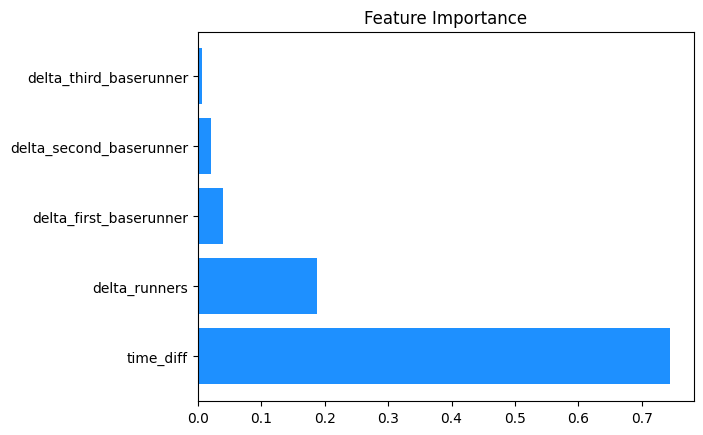

In [43]:
# plotting which features contributed most to the model's performance

best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

importances = best_rf.feature_importances_
feature_names = X.columns

plt.barh(feature_names, importances, color = 'dodgerblue')
plt.title("Feature Importance")
plt.show()

In [44]:
# querying plays where inning type is missing so I can fill it in

dirty = plays_summary_filled_binary[plays_summary_filled_binary['inning_type'].isna()]

In [45]:
# predicting the types for the missing values

missing_pred = best_rf.predict(dirty[['time_diff', 'delta_runners', 'delta_first_baserunner', 'delta_second_baserunner', 'delta_third_baserunner']])
missing_pred = list(map(lambda x: 'same' if x == 0 else 'switch', missing_pred))

In [46]:
# filling values in

plays_summary_filled_binary.loc[plays_summary_filled['inning_type'].isna(), 'inning_type'] = missing_pred

In [47]:
# manually changing some values due to baseball logic

plays_summary_filled_binary.loc[plays_summary_filled_binary['play_per_game']==1, 'inning_type'] = 'switch'

In [48]:
# getting indices for where top/bottom value is missing

missing_tbi_idx = plays_summary_filled_binary[
    (plays_summary_filled_binary['top_bottom_inning'].isna())# | plays_summary_filled_binary['top_bottom_inning'].shift(-1).isna()
].index

In [49]:
# filling in the values where top/bottom inning is missing

tbi_filled = plays_summary_filled_binary.copy()
print(tbi_filled['top_bottom_inning'].isna().sum())
missing_tbi_idx = tbi_filled[
    (tbi_filled['top_bottom_inning'].isna())
].index
for row in missing_tbi_idx:
    if row != 0:
        prev_tbi = tbi_filled.loc[row-1, 'top_bottom_inning']
        cur_tbi = tbi_filled.loc[row, 'top_bottom_inning']

        prev_it = tbi_filled.loc[row-1, 'inning_type']
        cur_it = tbi_filled.loc[row, 'inning_type']

        if cur_it == 'same':
            tbi_filled.loc[row, 'top_bottom_inning'] = prev_tbi
        else:
            fill_tbi = 'top' if prev_tbi == 'bottom' else 'bottom'
            tbi_filled.loc[row, 'top_bottom_inning'] = fill_tbi

tbi_filled.loc[
    (tbi_filled['top_bottom_inning'] != tbi_filled['top_bottom_inning'].shift(1)), 'inning_type'
    ] = 'switch'


tbi_filled['inning_id'] = (tbi_filled['inning_type']=='switch').cumsum()

print(tbi_filled['top_bottom_inning'].isna().sum())

7954
0


In [50]:
# distribution for inning type for all plays

tbi_filled['inning_type'].value_counts() / len(tbi_filled)

inning_type
same      0.938262
switch    0.061738
Name: count, dtype: float64

In [51]:
# reading in ball position data

ball_position_subset = readDataSubset('ball_pos')
ball_pos = ball_position_subset.to_table().to_pandas()

In [52]:
# calculating euclidean distance from home plate to ball's location
ball_pos['total_distance'] = np.sqrt(ball_pos['ball_position_x']**2 + ball_pos['ball_position_y']**2)

# grouping to see each play's furthest ball position
bp_grouped_max_dist = ball_pos.groupby(['game_str','play_id'])['total_distance'].max()

# grouping to see the ball's last x-coordinate for each play
bp_grouped_last_x = ball_pos.groupby(['game_str','play_id'])['ball_position_x'].last()

# grouping to see the ball's last x-coordinate for each play
bp_grouped_last_y = ball_pos.groupby(['game_str','play_id'])['ball_position_y'].last()

# grouping to see the ball's last total distance for each play
bp_grouped_last_dist = ball_pos.groupby(['game_str','play_id'])['total_distance'].last()


In [53]:
# function to help me find where infield ground balls are hit

def find_ground_ball(event_code_lst):
    player_seq = [i[0] for i in event_code_lst]
    ball_seq = [i[1] for i in event_code_lst]
    if len(event_code_lst) > 3:
        if 4 in ball_seq:
            gb_idx = ball_seq.index(4) + 1
            if ball_seq[gb_idx] == 16:
                return True
    return False

In [54]:
# function to return only plays of interest when given a dataset

def get_plays_of_interest(df):
    """
    Queries for plays where baserunners potentially have to make a choice on
    whether to stay or advance.
    
    """
    df = df.copy()

    # assigning base states
    bases_000 = (~df['first_baserunner']) & (~df['second_baserunner']) & (~df['third_baserunner'])
    bases_100 = (df['first_baserunner']) & (~df['second_baserunner']) & (~df['third_baserunner'])
    bases_110 = (df['first_baserunner']) & (df['second_baserunner']) & (~df['third_baserunner'])
    bases_101 = (df['first_baserunner']) & (~df['second_baserunner']) & (df['third_baserunner'])
    bases_010 = (~df['first_baserunner']) & (df['second_baserunner']) & (~df['third_baserunner'])
    bases_011 = (~df['first_baserunner']) & (df['second_baserunner']) & (df['third_baserunner'])
    bases_001 = (~df['first_baserunner']) & (~df['second_baserunner']) & (df['third_baserunner'])
    bases_111 = (df['first_baserunner']) & (df['second_baserunner']) & (df['third_baserunner'])
    
    # filtering desired base states
    base_state = df[
    bases_101 | bases_010 | bases_011 | bases_001
    ]

    # using find_ground_ball function to make sure ball is put in play and hits ground immediately
    gb_plays = base_state[base_state['event_code'].apply(find_ground_ball)]
    gb_plays = gb_plays.set_index(['game_str','play_id'])

    # adding ball's max total distance seen for each play
    gb_plays['ball_max_total_distance'] = bp_grouped_max_dist

    # filtering from potential plays if ball's maximum distance was in the infield
    return gb_plays[
        gb_plays['ball_max_total_distance'] < 180
    ].reset_index()

In [55]:
ioi = tbi_filled.copy()

# get data frame that only has the innings that have at least one play of interest
ioi_innings = get_plays_of_interest(ioi)['inning_id'].unique()
ioi = ioi[ioi['inning_id'].isin(ioi_innings)]

# add column for ball's max total distance for each play
ioi = ioi.set_index(['game_str','play_id']).assign(ball_max_total_distance = bp_grouped_max_dist).reset_index()

# add column for ball's last seen x-coordinate for each play
ioi = ioi.set_index(['game_str','play_id']).assign(ball_last_position_x = bp_grouped_last_x).reset_index()

# add column for ball's last seen y-coordinate for each play
ioi = ioi.set_index(['game_str','play_id']).assign(ball_last_position_y = bp_grouped_last_y).reset_index()


ioi['ab_diff'] = ioi['at_bat_y'].diff().where(ioi['inning_id']==ioi['inning_id'].shift(1), 1)

In [56]:
# most missing at bats in a half inning

ioi.groupby('inning_id')['at_bat_y'].agg(lambda x: x.isna().sum()).max()

np.int64(55)

In [57]:
# graph showing how many plays are lost when filtering proportion of nans per inning

mab_cuts = np.arange(.005, .4, .005)
all_lost_plays = list()
for cutoff in mab_cuts:
    lost_plays = get_plays_of_interest(ioi).shape[0]- get_plays_of_interest(ioi.groupby('inning_id').filter(lambda x: x['at_bat_y'].isna().mean() < cutoff)).shape[0]
    all_lost_plays.append(lost_plays)

px.scatter(x = mab_cuts, y = all_lost_plays, color_discrete_sequence=['dodgerblue'])

In [58]:
# mean time difference when at bat changes in the same game

plays_summary.dropna(subset='at_bat_y').groupby(['game_str', 'at_bat_y']).apply(lambda x: (x['timestamp_first'].shift(-1) - x['timestamp_last']).mean(), include_groups = False).mean()

np.float64(25874.561152101356)

In [59]:
# proportion of nan values permitted in innings of interest dataset
prop_nas_allowed_in_inning = .2

# grouping by unique inning and filtering so there aren't too many missing at bats
# when trying to impute missing at bats
ioi_filtered = (ioi.groupby('inning_id').filter(
    lambda x:
    x['ab_diff'].isna().mean() < prop_nas_allowed_in_inning
    and x['ab_diff'].mean() < 1
    and x['ab_diff'].mean() > 0
    and len(x['ab_diff']) >= 3
))

### Part 2: Imputing at bats so outs can be calculated

In [60]:
# getting data where values aren't missing

clean = ioi_filtered.dropna(subset = ['inning_type', 'delta_runners', 'time_diff', 'ab_diff']).copy()

In [61]:
# defining feature and target columns

X = clean[['time_diff','delta_runners','inning_type']]
y = clean['ab_diff'].apply(lambda x: 1 if x > 0 else 0)

In [62]:
# getting train, test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=seed)

In [63]:
# preparing columns so they work properly with model

prepro = ColumnTransformer(
    [('categorical', OneHotEncoder(handle_unknown='ignore'), ['inning_type'])],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [64]:
# building baseline pipeline

pipe = Pipeline([
    ('preprocessor', prepro),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=seed))
])

In [65]:
# training model

pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['inning_type'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=199))])

In [66]:
# baseline evaluation

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2041
           1       0.59      0.60      0.59       752

    accuracy                           0.78      2793
   macro avg       0.72      0.72      0.72      2793
weighted avg       0.78      0.78      0.78      2793



In [67]:
# tuning model for best accuracy using previous method 

param_grid = {
    'classifier__n_estimators': [250, 300, 350],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_samples_split': [2, 3, 5]
}

grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['inning_type'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=199))]),
             param_grid={'classifier__max_depth': [6, 7, 8],
                         'classifier__min_samples_split': [2, 3, 5],
                         'classifier__n_estimators': [250, 300, 350]},
             scoring='f1')

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      2041
           1       0.58      0.78      0.66       752

    accuracy                           0.79      2793
   macro avg       0.74      0.78      0.75      2793
weighted avg       0.82      0.79      0.79      2793



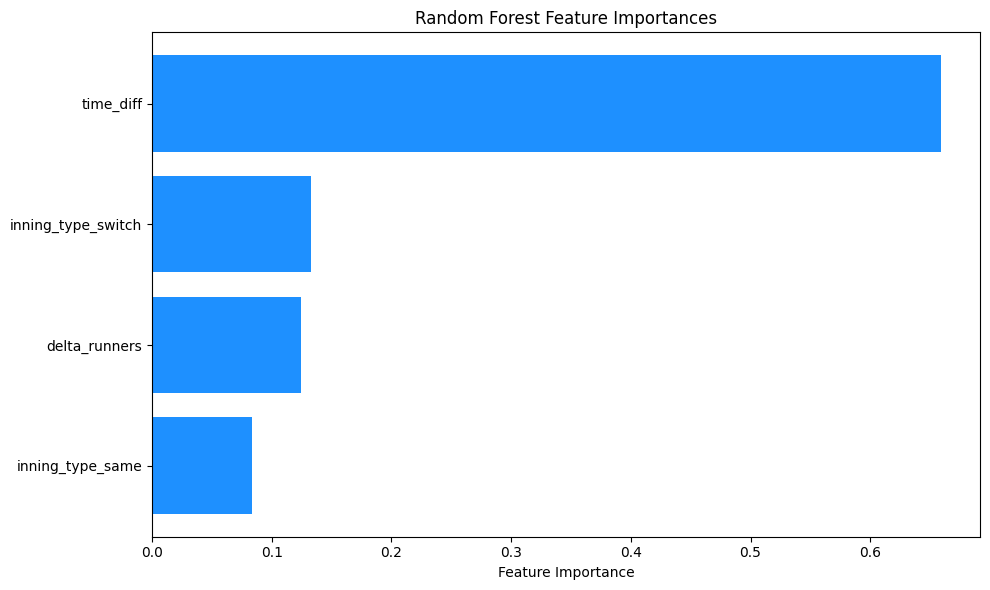

In [68]:
# plotting most important features used for this model

best_pipe = grid.best_estimator_

model = best_pipe.named_steps['classifier']
preprocessor = best_pipe.named_steps['preprocessor']

cat_feature_names = preprocessor.named_transformers_['categorical'].get_feature_names_out(['inning_type'])

all_feature_names = np.concatenate([cat_feature_names, ['time_diff', 'delta_runners']])

feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True) 

y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='dodgerblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

In [69]:
print("Best parameters:", grid.best_params_)
print("Best F1 score on validation set:", grid.best_score_)

Best parameters: {'classifier__max_depth': 6, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 350}
Best F1 score on validation set: 0.6776577398453317


In [70]:
# filling in missing differences in at bats

ab_diff_filled = ioi_filtered.copy()
ab_diff_filled.loc[ioi_filtered['ab_diff'].isna(), 'ab_diff'] = grid.predict(ab_diff_filled.loc[ioi_filtered['ab_diff'].isna(), ['time_diff','delta_runners','inning_type']])

In [71]:
# filling in missing at bats with predicted ab_diffs

ab_diff_filled = ioi_filtered.copy()
miss_ab_pred = grid.predict(ab_diff_filled.loc[ioi_filtered['ab_diff'].isna(), ['time_diff','delta_runners','inning_type']])
ab_diff_filled.loc[ioi_filtered['ab_diff'].isna(), 'ab_diff'] = miss_ab_pred

ab_filled = ab_diff_filled.copy()
# manual data insertion for rare case
# ab_filled.loc[13526, 'at_bat_y'] = 26
missing_ab_idx = ab_filled[ab_filled['at_bat_y'].isna()].index.to_list()
for i in missing_ab_idx:
    # filling in place if row is in index
    if i-1 in ab_filled.index:
        prev_ab = ab_filled.loc[i-1, 'at_bat_y']
    # filling with bfill from unfiltred dataset if there aren't enough non nan values close by    
    elif np.isnan(tbi_filled.loc[i-1, 'at_bat_y']):
        prev_ab = tbi_filled['at_bat_y'].bfill().loc[i-1]
    # filling with unfiltered dataset to get previous values
    else:
        prev_ab = tbi_filled.loc[i-1, 'at_bat_y']

    curr_ab_diff = ab_filled.loc[i, 'ab_diff']
    ab_filled.loc[i, 'at_bat_y'] = prev_ab + curr_ab_diff

ab_filled['ab_id'] = (ab_filled['at_bat_y'] != ab_filled['at_bat_y'].shift()).cumsum()

In [72]:
# use to calculate outs more confidently
accurate = ab_filled.copy()
accurate.loc[0, 'outs_diff'], accurate.loc[0, 'confidence'] = 0, 2

# use to calculate outs less confidently (proportion of plays with 2 outs)
inaccurate = ioi[~ioi['inning_id'].isin(ab_filled['inning_id'].unique())].copy()

## Stage 3: Calculating Outs and Filtering Plays of Interest

In [73]:
# attempt to calculate difference in outs based on logical baseball possibilities

for row in accurate.index:
    prev_row = row-1
    if prev_row in accurate.index:
        prev_game = accurate.loc[prev_row, 'game_str']
        curr_game = accurate.loc[row, 'game_str']

        prev_inn = accurate.loc[prev_row, 'inning_id']
        curr_inn = accurate.loc[row, 'inning_id']

        prev_ab = accurate.loc[prev_row, 'ab_id']
        curr_ab = accurate.loc[row, 'ab_id']

        prev_total_br = accurate.loc[prev_row, runner_cols].values
        curr_total_br = accurate.loc[row, runner_cols].values

        prev_fbr = accurate.loc[prev_row, runner_cols[0]]
        prev_sbr = accurate.loc[prev_row, runner_cols[1]]
        prev_tbr = accurate.loc[prev_row, runner_cols[2]]

        curr_fbr = accurate.loc[row, runner_cols[0]]
        curr_sbr = accurate.loc[row, runner_cols[1]]
        curr_tbr = accurate.loc[row, runner_cols[2]]
        
        curr_dr = accurate.loc[row, 'delta_runners']

        curr_dr_cols = accurate.loc[row, delta_runner_cols]

        prev_event_codes = accurate.loc[prev_row, 'event_code']
        prev_pos_seq = [i[0] for i in prev_event_codes]
        prev_ball_seq = [i[1] for i in prev_event_codes]

        curr_event_codes = accurate.loc[row, 'event_code']
        curr_pos_seq = [i[0] for i in curr_event_codes]
        curr_ball_seq = [i[1] for i in curr_event_codes]

        prev_bmd = accurate.loc[prev_row, 'ball_max_total_distance']
        curr_bmd = accurate.loc[row, 'ball_max_total_distance']

        prev_blx = accurate.loc[prev_row, 'ball_last_position_x']
        curr_blx = accurate.loc[row, 'ball_last_position_x']

        prev_bly = accurate.loc[prev_row, 'ball_last_position_y']
        curr_bly = accurate.loc[row, 'ball_last_position_y']

        # any ball hit in play in infield range
        infield_ground_ball =  16 in prev_ball_seq and prev_bmd.round() in range(80, 170) and 6 not in prev_ball_seq
        infield_ground_ball_1b = infield_ground_ball and prev_blx.round() in range(40, 90)
        ball_caught_air = 4 in prev_ball_seq and 2 in prev_ball_seq and 16 not in prev_ball_seq
        outfield_ground_ball = prev_bmd > 170 and 16 in prev_ball_seq

        if prev_inn == curr_inn:
            # home runs
            if 11 in prev_ball_seq:
                accurate.loc[row, 'outs_diff'] = 0
                accurate.loc[row, 'confidence'] = 2
            # popups/lineouts/flyouts (ball never touched ground)
            elif ball_caught_air:
                accurate.loc[row, 'outs_diff'] = 1
                accurate.loc[row, 'confidence'] = 2
            # infield ground balls ending at firstbase
            elif infield_ground_ball and prev_ab != curr_ab:
                # add out if batter isn't on first
                if not curr_fbr:
                    accurate.loc[row, 'outs_diff'] = 1
                # add out if first baserunner doesn't advance 
                    if prev_fbr and not curr_sbr:# any([curr_sbr, curr_tbr]):
                        accurate.loc[row, 'outs_diff'] = 2
                # lower confidence because runners can advance more than 1 base but unlikely
                accurate.loc[row, 'confidence'] = 0
            # no outs gained when ball is hit in outfield and lands on ground
            elif outfield_ground_ball:
                accurate.loc[row, 'outs_diff'] = 0
                accurate.loc[row, 'confidence'] = 1
            # no change in runners likely means an out
            elif prev_ab != curr_ab and curr_dr == 0 and not (any(curr_dr_cols > 0) and any(curr_dr_cols < 0)):
                accurate.loc[row, 'outs_diff'] = 1
                accurate.loc[row, 'confidence'] = 1
            # any increase in baserunners means no outs gained
            elif prev_ab != curr_ab and curr_dr > 0:
                accurate.loc[row, 'outs_diff'] = 0
                accurate.loc[row, 'confidence'] = 1
            elif prev_ab == curr_ab:
                if curr_dr < 0:
                    accurate.loc[row, 'outs_diff'] = 1
                else:
                    accurate.loc[row, 'outs_diff'] = 0
                accurate.loc[row, 'confidence'] = 0
        else:
            accurate.loc[row, 'outs_diff'] = 0
            accurate.loc[row, 'confidence'] = 2

In [74]:
# getting proportion of outs_diff to impute missing outs_diff values
od_props = accurate['outs_diff'].value_counts()/(len(accurate.dropna(subset = 'outs_diff')))

# randomly imputing missing values
accurate.loc[accurate['outs_diff'].isna(), 'outs_diff'] = np.random.choice(od_props.keys(), accurate['outs_diff'].isna().sum(), p = od_props.values)

# setting confidence to 0 for all missing values
accurate.loc[accurate['confidence'].isna(), 'confidence'] = 0

# adding column to cumulatively sum up confidence values for each inning
# sum is then divided by its proportion of the maximum value of confidence at that play in the inning
accurate['confidence_prop'] = accurate.groupby('inning_id')['confidence'].transform(lambda x: x.cumsum() / (np.arange(1, len(x) + 1)))
accurate.groupby('inning_id')['outs_diff'].sum().describe()

count    572.000000
mean       3.082168
std        2.068502
min        0.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       17.000000
Name: outs_diff, dtype: float64

In [75]:
accurate['outs_diff_filtered'] = 0

# Group by inning
for inning_id, group in accurate.groupby('inning_id'):
    non_zero_outs = group[group['outs_diff'] != 0]
    
    if len(non_zero_outs) == 0:
        continue
    elif len(non_zero_outs) == 1:
        # Only one non-zero play, keep that
        idx = non_zero_outs.index[0]
        accurate.loc[idx, 'outs_diff_filtered'] = accurate.loc[idx, 'outs_diff']
    else:
        # More than one, keep first and last only
        first_idx = non_zero_outs.index[0]
        last_idx = non_zero_outs.index[-1]
        accurate.loc[first_idx, 'outs_diff_filtered'] = accurate.loc[first_idx, 'outs_diff']
        accurate.loc[last_idx, 'outs_diff_filtered'] = accurate.loc[last_idx, 'outs_diff']


In [76]:
# using difference in outs to calculate outs per play

accurate.loc[accurate['inning_type']=='switch', 'outs'] = 0
for row in accurate.index:
    if row-1 in accurate.index:
        prev_inn = accurate.loc[row-1,'inning_id']
        curr_inn = accurate.loc[row,'inning_id']
        prev_outs = accurate.loc[row-1,'outs']
        outs_diff = accurate.loc[row, 'outs_diff_filtered']
        if prev_inn == curr_inn:
            if prev_outs + outs_diff == 3:
                prev_outs -= 1
            accurate.loc[row, 'outs'] = prev_outs + outs_diff

In [77]:
outs_distribution = accurate['outs'].value_counts()/len(accurate)
outs_distribution

outs
1.0    0.486940
0.0    0.319822
2.0    0.193238
Name: count, dtype: float64

In [78]:
# probabilistically imputing the number of outs for each play using more accurate distribution

for inning in inaccurate['inning_id'].unique():

    inning_df = inaccurate[inaccurate['inning_id']==inning].copy()
    start_idx = inning_df.index[0]
    outs_0 = start_idx + round(inning_df.shape[0] * outs_distribution.loc[0])
    outs_1 = outs_0 + round(inning_df.shape[0] * outs_distribution.loc[1])
    # outs_2 = outs_1 + int(inning_df.shape[0] * outs_distribution.loc[2])

    inaccurate.loc[start_idx:outs_0, 'outs'] = 0
    inaccurate.loc[outs_0:outs_1, 'outs'] = 1
    inaccurate.loc[outs_1:, 'outs'] = 2

inaccurate['confidence'] = 0

In [79]:
# same as old function to get poi, but now it filters for outs

def get_plays_of_interest_outs(df):
    df = df[df['outs']<2].copy()
    return get_plays_of_interest(df)

In [80]:
# defining dataset that only has plays of interest

poi_raw = pd.concat([get_plays_of_interest_outs(accurate), get_plays_of_interest_outs(inaccurate)]).reset_index(drop=True)
poi_raw['confidence_prop'] = poi_raw['confidence_prop'].fillna(0)

# removing plays where next base state is unavailable
# because it is hard to determine if runners were safe and it likely means it was the last out

missing_next_play = list()
mislabeled_innning_switch = list()
for row in poi_raw.index:
    game = poi_raw.loc[row, 'game_str']
    inn = poi_raw.loc[row, 'inning_id']
    pid = poi_raw.loc[row, 'play_id']
    
    
    next_play = tbi_filled[
        (tbi_filled['game_str']==game) & (tbi_filled['inning_id']==inn) & (tbi_filled['play_id']==pid+1)
    ]

    if next_play.shape[0] == 0:
        missing_next_play.append(row)
    else:
        next_td = abs(next_play['time_diff'].iloc[0])
        if next_td > best_split:
            mislabeled_innning_switch.append(row)

poi = poi_raw.drop(missing_next_play + mislabeled_innning_switch).reset_index(drop=True)

In [81]:
poi['ball_last_total_distance'] = bp_grouped_last_dist.loc[poi.set_index(['game_str','play_id']).index].values

In [82]:
def filter_large_df(large_df, poi_df, merge_cols = ['game_str', 'play_id']):
    poi_df_merge_cols = poi_df[merge_cols]
    return large_df.merge(poi_df_merge_cols, on = merge_cols, how = 'inner', copy = False)

In [83]:
# had to create different function to avoid memory shortage errors

def filter_large_df(large_df, poi_df, merge_cols=('game_str', 'play_id')):
    keys = poi_df.loc[:, merge_cols].drop_duplicates(ignore_index=True)
    for c in merge_cols:
        if keys[c].dtype != large_df[c].dtype:
            keys[c] = keys[c].astype(large_df[c].dtype, copy=False)
    return large_df.merge(keys, on=list(merge_cols), how='inner', sort=False, copy=False)

In [84]:
# filter large dataset for only plays of interest to make future querying much faster

player_pos_poi = filter_large_df(player_pos, poi)

In [85]:
def filter_large_df(large_df, poi_df, merge_cols = ['game_str', 'play_id']):
    poi_df_merge_cols = poi_df[merge_cols]
    return large_df.merge(poi_df_merge_cols, on = merge_cols, how = 'inner', copy = False)

In [86]:
# filter large dataset for only plays of interest to make future querying much faster

game_events_poi = filter_large_df(game_events, poi)

In [87]:
# filter large dataset for only plays of interest to make future querying much faster

ball_pos_poi = filter_large_df(ball_pos, poi)

In [88]:
# creates new dataframe with one row per runner

columns = [
    'game_str',
    'play_id',
    'inning_id',
    'runner',
    'adv_att',
    'safe',
    'base_state',
    'outs',
    'outs_confidence',
    'event_code',
    'ball_last_total_distance',
    'fielded_by'
]

# need to assign columns in this format so it handles event_code lists properly
poi_expanded = pd.DataFrame({column: pd.Series(dtype='object') for column in columns}
    
)
idx = 0

for row in poi.index:
    game = poi.loc[row, 'game_str']
    pid = poi.loc[row, 'play_id']
    inning = poi.loc[row, 'inning_id']
    event_code = poi.loc[row, 'event_code']
    fbr = poi.loc[row, 'first_baserunner']
    sbr = poi.loc[row, 'second_baserunner']
    tbr = poi.loc[row, 'third_baserunner']
    bld = poi.loc[row, 'ball_last_total_distance']
    outs = poi.loc[row, 'outs']
    confidence = poi.loc[row, 'confidence']

    next_play = tbi_filled.loc[
            (tbi_filled['game_str']==game) & (tbi_filled['play_id']==pid+1) & (tbi_filled['inning_id']==inning),
            ['second_baserunner', 'third_baserunner']
        ].iloc[0]
    next_sbr = next_play['second_baserunner']
    next_tbr = next_play['third_baserunner']

    if sbr:
        poi_expanded.loc[idx, 'game_str'] = game
        poi_expanded.loc[idx, 'play_id'] = pid
        poi_expanded.loc[idx, 'inning_id'] = inning
        poi_expanded.loc[idx, 'event_code'] = event_code
        poi_expanded.loc[idx, 'runner'] = '2B'
        poi_expanded.loc[idx, 'ball_last_total_distance'] = bld
        poi_expanded.loc[idx, 'base_state'] = f'{int(fbr)}{int(sbr)}{int(tbr)}'
        poi_expanded.loc[idx, 'outs'] = outs
        poi_expanded.loc[idx, 'outs_confidence'] = confidence

        if not next_sbr:
            attempt = True
        else:
            attempt = False
        poi_expanded.loc[idx, 'adv_att'] = attempt

        if attempt:
            if next_tbr:
                safe = True
            else:
                safe = False
            poi_expanded.loc[idx, 'safe'] = safe  

        idx += 1

    if tbr:
        poi_expanded.loc[idx, 'game_str'] = game
        poi_expanded.loc[idx, 'play_id'] = pid
        poi_expanded.loc[idx, 'inning_id'] = inning
        poi_expanded.loc[idx, 'event_code'] = event_code
        poi_expanded.loc[idx, 'runner'] = '3B'
        poi_expanded.loc[idx, 'ball_last_total_distance'] = bld
        poi_expanded.loc[idx, 'base_state'] = f'{int(fbr)}{int(sbr)}{int(tbr)}'
        poi_expanded.loc[idx, 'outs'] = outs
        poi_expanded.loc[idx, 'outs_confidence'] = confidence

        if not next_tbr or (sbr and not next_sbr):
            attempt = True
        else:
            attempt = False
        poi_expanded.loc[idx, 'adv_att'] = attempt

        if attempt:
            if (2,2) not in event_code or event_code[event_code.index((2,2)) + 1] == (2,3):
                safe = True
            else:
                # find timestamp when ball is received close to home
                play_df = play_lookup(game_events_poi, game, pid)
                time_ball_at_home = play_df[(play_df['player_position']==2) & (play_df['event_code']==2)]['timestamp'].iloc[0]

                # find baserunner's distance from home at time ball is close to home
                player_df = play_lookup(player_pos_poi, game, pid)
                player_pos_home = player_df[(player_df['player_position']==13) & (player_df['timestamp']==time_ball_at_home)]['total_distance'].min()

                # find ball's distance from home at time ball is close to home
                ball_df = play_lookup(ball_pos_poi, game, pid)
                ball_pos_home = ball_df[(ball_df['timestamp']==time_ball_at_home)]['total_distance'].iloc[0]

                # determine if runner was safe if their distance was less than the ball's at the same timestamp
                safe = player_pos_home < ball_pos_home

            poi_expanded.loc[idx, 'safe'] = safe

        idx += 1
    

In [89]:
# gets the position of the player who fielded the ball

def find_fielder_position(event_code):
    idx = event_code.index((10,4)) + 1
    while event_code[idx] == (255,16):
        idx+=1
    return event_code[idx][0]

In [90]:
# add column for position of fielder

poi_expanded['fielded_by'] = poi_expanded['event_code'].apply(find_fielder_position)

In [91]:
# function to get the coordinates for the player who fielded the ground ball

def get_receiving_fielder_location(game, pid, fielder_position):
    timestamp_moe = 25

    play_df = play_lookup(game_events_poi, game, pid)
    time_ball_received = play_df[
        (play_df['player_position']==fielder_position)
        # event codes for when fielder either recieves ball or it deflects off him
        & (play_df['event_code'].isin([2,9]))
    ]['timestamp'].iloc[0]
    time_lower = time_ball_received-timestamp_moe
    time_higher = time_ball_received+timestamp_moe

    player_df = play_lookup(player_pos_poi, game, pid)
    player_df = player_df[
        (player_df['player_position']==fielder_position) & (player_df['timestamp'].isin(range(time_lower, time_higher)))
    ]

    x = player_df['field_x'].iloc[0]
    y = player_df['field_y'].iloc[0]
    total = np.sqrt(x**2+y**2)
    return x,y,total


In [92]:
# adding columns for the positioning of the fielder when he fielded the ball

fielder_locations = poi_expanded.apply(lambda x: get_receiving_fielder_location(x['game_str'], x['play_id'], x['fielded_by']), axis = 1, result_type='expand')
poi_expanded['fielder_pos_x'], poi_expanded['fielder_pos_y'], poi_expanded['fielder_pos_total'] = fielder_locations[0], fielder_locations[1], fielder_locations[2]

In [93]:
# function to calculate the time at which the infielder fielded the ground ball

def calculate_time_to_fielder(game, pid, fielder_position, use_seconds = False):
    play_df = play_lookup(game_events_poi, game, pid)

    time_ball_hit = play_df.loc[(play_df['player_position']==10) & (play_df['event_code']==4), 'timestamp'].iloc[0]
    time_ball_received = play_df.loc[(play_df['player_position']==fielder_position) & (play_df['event_code'].isin([2,9])), 'timestamp'].iloc[0]

    time_diff = time_ball_received - time_ball_hit

    if use_seconds:
        time_diff /= 1000

    return time_diff

In [94]:
# add column to calculate how long it took when ball was hit to reach the fielder

poi_expanded['time_to_fielder'] = poi_expanded.apply(lambda x: calculate_time_to_fielder(x['game_str'], x['play_id'], x['fielded_by']), axis = 1)

In [95]:
# function to find where the baserunner started the play at

def get_baserunner_starting_location(game, pid, baserunner):
    timestamp_moe = 25
    baserunner_map = {'2B':12, '3B':13}
    baserunner = baserunner_map[baserunner]

    play_df = play_lookup(game_events_poi, game, pid)
    start_time = play_df['timestamp'].iloc[0]
    time_lower = start_time-timestamp_moe
    time_higher = start_time+timestamp_moe

    player_df = play_lookup(player_pos_poi, game, pid)
    player_df = player_df[
        (player_df['player_position']==baserunner) & (player_df['timestamp'].isin(range(time_lower, time_higher)))
    ]

    x = player_df['field_x'].iloc[0]
    y = player_df['field_y'].iloc[0]
    total = np.sqrt(x**2+y**2)
    return x,y,total

In [96]:
# adding columns for the positioning of the baserunner at the start of the play

runner_start_locations = poi_expanded.apply(lambda x: get_baserunner_starting_location(x['game_str'], x['play_id'], x['runner']), axis = 1, result_type='expand')
poi_expanded['runner_start_pos_x'], poi_expanded['runner_start_pos_y'], poi_expanded['runner_start_pos_total'] = runner_start_locations[0], runner_start_locations[1], runner_start_locations[2]

In [97]:
# function to calculate the rate of change from one timestamp to the next

def calculate_roc(df, x_col, y_col, time_col, ms_to_sec = True):
    diff_x = df[x_col].diff()
    diff_y = df[y_col].diff()
    diff_time = df[time_col].diff()

    if ms_to_sec:
        diff_time = diff_time / 1000

    return (np.sqrt(diff_x**2 + diff_y**2) / diff_time).dropna()

In [98]:
# function to calculate a baserunners speed in a given play

def calculate_runner_speed(game, pid, baserunner, use_mph = False):
    baserunner_map = {'2B':12, '3B':13}
    baserunner = baserunner_map[baserunner]
    ft_sec_to_mph = 3600/5280

    player_df = play_lookup(player_pos_poi, game, pid)
    player_df = player_df[player_df['player_position']==baserunner]

    sprint_speeds = calculate_roc(player_df, 'field_x', 'field_y', 'timestamp')

    if use_mph:
        sprint_speeds = sprint_speeds * ft_sec_to_mph

    return sprint_speeds.max()

In [99]:
# add column for maximum sprint speed seen for the runner

poi_expanded['runner_sprint_speed'] = poi_expanded.apply(lambda x: calculate_runner_speed(x['game_str'], x['play_id'], x['runner']), axis = 1)


In [100]:
# function to calculate how fast the fielder threw the ball after he fielded it

def calculate_throw_speed(game, pid, event_code, fielder_position, percentile = 90,  use_mph = True):
    timestamp_moe = 25
    ft_sec_to_mph = 3600/5280

    if (fielder_position, 3) in event_code:
        play_df = play_lookup(game_events_poi, game, pid)
        throw_idx = play_df[
            (play_df['player_position']==fielder_position)
            # event codes for when fielder either recieves ball or it deflects off him
            & (play_df['event_code']==3)
        ].index[0]

        time_throw = game_events_poi.loc[throw_idx, 'timestamp'] - timestamp_moe
        time_after_throw = game_events_poi.loc[throw_idx+1, 'timestamp'] + timestamp_moe

        ball_df = play_lookup(ball_pos_poi, game, pid)
        ball_df = ball_df[
            (ball_df['timestamp'] >= time_throw) & (ball_df['timestamp'] <= time_after_throw)
        ]

        speeds = calculate_roc(ball_df, 'ball_position_x', 'ball_position_y', 'timestamp')

        if use_mph:
            speeds = speeds * ft_sec_to_mph

        return np.percentile(speeds, percentile)

    return np.nan

In [101]:
# adding column for arm strength

poi_expanded['fielder_arm_strength'] = poi_expanded.apply(lambda x: calculate_throw_speed(x['game_str'], x['play_id'], x['event_code'], x['fielded_by']), axis = 1)

In [102]:
# function to calculate the ball's exit velocity off the bat after a specified number of first frames

def calculate_exit_velo(game, pid, frames_after_hit = None, use_mph = True):
    timestamp_moe = 25
    ft_sec_to_mph = 3600/5280

    play_df = play_lookup(game_events_poi, game, pid)
    time_ball_hit_idx = play_df.loc[(play_df['player_position']==10) & (play_df['event_code']==4)].index[0]
    time_ball_hit = play_df.loc[time_ball_hit_idx, 'timestamp'] - timestamp_moe
    time_after_ball_hit = play_df.loc[time_ball_hit_idx+1, 'timestamp'] + timestamp_moe

    ball_df = play_lookup(ball_pos_poi, game, pid)
    ball_df = ball_df[(ball_df['timestamp'] >= time_ball_hit) & (ball_df['timestamp'] <= time_after_ball_hit)]

    evs = calculate_roc(ball_df, 'ball_position_x', 'ball_position_y', 'timestamp')

    if use_mph:
        evs = evs * ft_sec_to_mph
    
    evs_frames = evs[:frames_after_hit]


    return evs_frames.mean()

In [103]:
# finding which number of first frames produces the lowest variance in exit velocities so we avoid extreme values

stds = list()
frames = list(range(1,20)) + [None]
for i in frames:
    evs = poi_expanded.apply(lambda x: calculate_exit_velo(x['game_str'], x['play_id'], i), axis = 1)
    stds.append(evs.std())

In [104]:
# boring but somewhat useful graph to see the dropoff in the rate at which std decreases
# this is simply more EDA

px.scatter(x = frames, y = stds, labels = {'x':'First Frames Used', 'y':'Standard Deviation'}, color_discrete_sequence=['dodgerblue'])

In [105]:
# best number of first frames to use

best_frames = frames[stds.index(min(stds))]

In [106]:
# adding column for ball's exit velocity

poi_expanded['exit_velo'] = poi_expanded.apply(lambda x: calculate_exit_velo(x['game_str'], x['play_id'], best_frames), axis = 1)

# adding binary categorization for exit velos due to unreasonable values seen

poi_expanded['hard_hit'] = poi_expanded['exit_velo'] > 100

# adding multiple categories for exit velo

exit_velo_cats = [0, 50, 90, 120, 150, np.inf]
poi_expanded['exit_velo_cats'] = (pd.cut(poi_expanded['exit_velo'], exit_velo_cats, labels = ['very_soft','soft','medium','hard','very_hard']))

In [107]:
# more EDA to see how off the miscalculations are
# EVs tend to run high with multiple outliers, so it may be best to create bins

px.histogram(poi_expanded, 'exit_velo', color_discrete_sequence=['dodgerblue'], title = 'Exit Velocity Distribution')

## Stage 4: Predicting a Baserunner's Safety

In [108]:
# defining which features are categorical and numerical

categorical_features = [
    'runner',
    'base_state',
    'fielded_by',
    'exit_velo_cats'
]

numerical_features = [
    'outs',
    'outs_confidence',
    'fielder_pos_x',
    'fielder_pos_y',
    'fielder_pos_total',
    'time_to_fielder',
    'runner_start_pos_x',
    'runner_start_pos_y',
    'runner_start_pos_total',
    'runner_sprint_speed',
    'fielder_arm_strength',
    'exit_velo',
    'hard_hit'
]

In [109]:
# importing new model

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [110]:
# only training on plays where runner attempted to advance so it can be determined if they were successful or not

clean = poi_expanded[poi_expanded['adv_att']]
X = clean[categorical_features+numerical_features]
y = clean['safe'].apply(bool)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=199)

In [112]:
preprocessor = ColumnTransformer( 
    [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
)

In [113]:
# building base pipeline

xgb_clf_pipe_base = Pipeline(
    [
        ('preproc', preprocessor),
        ('classifier', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=seed
        ))
    ]
)

In [114]:
# training base model

xgb_clf_pipe_base.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['runner', 'base_state',
                                                   'fielded_by',
                                                   'exit_velo_cats']),
                                                 ('num', StandardScaler(),
                                                  ['outs', 'outs_confidence',
                                                   'fielder_pos_x',
                                                   'fielder_pos_y',
                                                   'fielder_pos_total',
                                                   'time_to_fielder',
                                                   'runner_start_pos_x',
                                                   'runner_start_pos_y',
                                                   'runner_start_pos_total',
                                                   'ru...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [115]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, make_scorer, f1_score

In [116]:
y_pred = xgb_clf_pipe_base.predict(X_test)
y_proba = xgb_clf_pipe_base.predict_proba(X_test)[:, 1]

In [117]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

[[ 3  5]
 [ 4 72]]
              precision    recall  f1-score   support

       False     0.4286    0.3750    0.4000         8
        True     0.9351    0.9474    0.9412        76

    accuracy                         0.8929        84
   macro avg     0.6818    0.6612    0.6706        84
weighted avg     0.8868    0.8929    0.8896        84

ROC AUC Score: 0.7236842105263158


In [118]:
# building new pipeline for fine-tuning

xgb_clf_pipe = Pipeline(
    [
        ('preproc', preprocessor),
        ('classifier', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state = seed
        ))
    ]
)

In [119]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.7, 0.9],
    'classifier__colsample_bytree': [0.7, 0.9],
    'classifier__reg_alpha': [0, 0.1, 1],
    'classifier__reg_lambda': [1, 10],
    'classifier__scale_pos_weight': [1,3,5]
}

In [120]:
# building cross-validation model to find the best combination of parameters

cv = StratifiedKFold(n_splits=5, shuffle=True)

grid_search_xgb = GridSearchCV(
    estimator=xgb_clf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(f1_score, pos_label=False),  # prioritize catching "out"
    verbose=2,
    n_jobs=-1
)

In [121]:
# running model to find best parameters

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['runner',
                                                                          'base_state',
                                                                          'fielded_by',
                                                                          'exit_velo_cats']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['outs',
                                                                          'outs_confidence',
                                                                          'fielder_pos_x',
                                                                          'fielder_pos_y',
                                                                          'fielder_pos_total',
                                                                          'ti...
             param_grid={'classifier__colsample_bytree': [0.7, 0.9],
                         'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__reg_alpha': [0, 0.1, 1],
                         'classifier__reg_lambda': [1, 10],
                         'classifier__scale_pos_weight': [1, 3, 5],
                         'classifier__subsample': [0.7, 0.9]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=False),
             verbose=2)

In [122]:
best_model_grid = grid_search_xgb.best_estimator_

y_pred_grid = best_model_grid.predict(X_test)
y_proba_grid = best_model_grid.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_grid))

[[ 3  5]
 [ 2 74]]
              precision    recall  f1-score   support

       False       0.60      0.38      0.46         8
        True       0.94      0.97      0.95        76

    accuracy                           0.92        84
   macro avg       0.77      0.67      0.71        84
weighted avg       0.90      0.92      0.91        84

ROC AUC Score: 0.7828947368421052


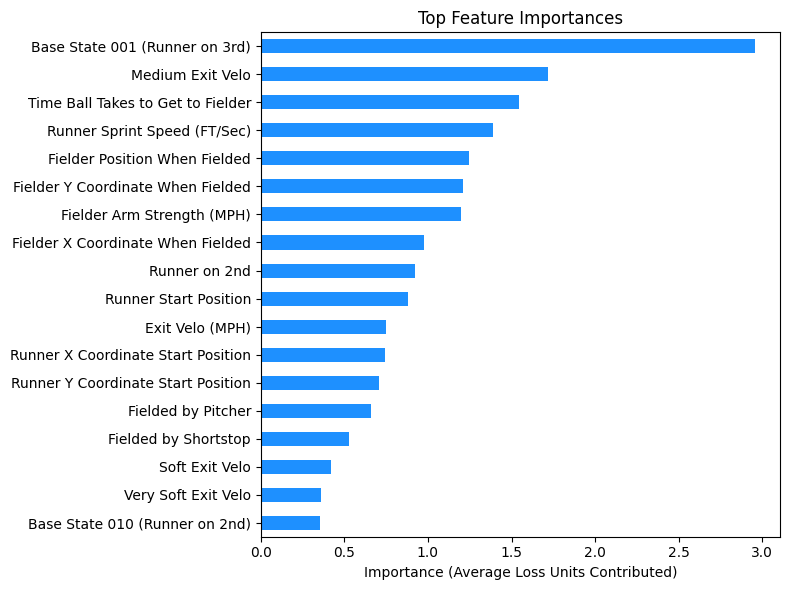

In [123]:
# plotting most valuable features

preprocessor = best_model_grid.named_steps['preproc']

# categorical transformer's feature names
cat_features = ['runner', 'base_state', 'fielded_by', 'exit_velo_cats']
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

# numerical features 
num_feature_names = preprocessor.transformers_[1][2] 

full_feature_names = list(cat_feature_names) + list(num_feature_names)

feature_name_mapping = {
    'runner_2B': 'Runner on 2nd',
    'runner_3B': 'Runner on 3rd',
    'base_state_001': 'Base State 001 (Runner on 3rd)',
    'base_state_010': 'Base State 010 (Runner on 2nd)',
    'base_state_011': 'Base State 011 (Runners on 2nd & 3rd)',
    'base_state_101': 'Base State 101 (Runners on 1st & 3rd)',
    'fielded_by_1.0': 'Fielded by Pitcher',
    'fielded_by_2.0': 'Fielded by Catcher',
    'fielded_by_3.0': 'Fielded by First Baseman',
    'fielded_by_4.0': 'Fielded by Second Baseman',
    'fielded_by_5.0': 'Fielded by Third Baseman',
    'fielded_by_6.0': 'Fielded by Shortstop',
    'exit_velo_cats_hard': 'Hard Exit Velo',
    'exit_velo_cats_medium': 'Medium Exit Velo',
    'exit_velo_cats_soft': 'Soft Exit Velo',
    'exit_velo_cats_very_hard': 'Very Hard Exit Velo',
    'exit_velo_cats_very_soft': 'Very Soft Exit Velo',
    'outs': 'Outs',
    'outs_confidence': 'Outs Confidence',
    'fielder_pos_x': 'Fielder X Coordinate When Fielded',
    'fielder_pos_y': 'Fielder Y Coordinate When Fielded',
    'fielder_pos_total': 'Fielder Position When Fielded',
    'time_to_fielder': 'Time Ball Takes to Get to Fielder',
    'runner_start_pos_x': 'Runner X Coordinate Start Position',
    'runner_start_pos_y': 'Runner Y Coordinate Start Position',
    'runner_start_pos_total': 'Runner Start Position',
    'runner_sprint_speed': 'Runner Sprint Speed (FT/Sec)',
    'fielder_arm_strength': 'Fielder Arm Strength (MPH)',
    'exit_velo': 'Exit Velo (MPH)',
    'hard_hit': 'Is Hard Hit (100 MPH+)'
}

# feature importance
booster = best_model_grid.named_steps['classifier'].get_booster()
xgb_importance = booster.get_score(importance_type='gain')

# map default tags to real feature names
mapped_importance = {full_feature_names[int(k[1:])]: v for k, v in xgb_importance.items()}
importance_series = pd.Series(mapped_importance).sort_values()

# change feature names to interpretable English names
importance_series = importance_series.rename(index=feature_name_mapping)

importance_series.plot(kind='barh', figsize=(8, 6), title="Top Feature Importances", color = 'dodgerblue')
plt.xlabel("Importance (Average Loss Units Contributed)")
plt.tight_layout()
plt.show()

In [124]:
# defining more hyperparameters to fine-tune

param_grid_fine = {
    'classifier__n_estimators': [150, 200, 250],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [5, 10, 15],
    'classifier__scale_pos_weight': [1, 2]
}

In [125]:
grid_search_xgb.best_params_

{'classifier__colsample_bytree': 0.7,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 200,
 'classifier__reg_alpha': 0.1,
 'classifier__reg_lambda': 1,
 'classifier__scale_pos_weight': 1,
 'classifier__subsample': 0.9}

In [126]:
# now using a randomized grid search to test more parameters in a relatively short amount of time

rand_search_xgb = RandomizedSearchCV(
    xgb_clf_pipe,
    param_distributions=param_grid_fine,
    n_iter=1000,  # increase if you want a deeper search
    scoring=make_scorer(f1_score, average='macro'),  # tune to your goal
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=seed
)

In [127]:
rand_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['runner',
                                                                                'base_state',
                                                                                'fielded_by',
                                                                                'exit_velo_cats']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['outs',
                                                                                'outs_confidence',
                                                                                'fielder_pos_x',
                                                                                'fielder_pos_y',
                                                                                'fielder_pos_total',
                                                                                'time_to_fielder',
                                                                                'runner_start_pos_x',
                                                                                'runner_start_p...
                                        'classifier__learning_rate': [0.05, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 4, 5, 6,
                                                                  7],
                                        'classifier__n_estimators': [150, 200,
                                                                     250],
                                        'classifier__reg_alpha': [0, 0.01, 0.1],
                                        'classifier__reg_lambda': [5, 10, 15],
                                        'classifier__scale_pos_weight': [1, 2],
                                        'classifier__subsample': [0.8, 0.9,
                                                                  1.0]},
                   random_state=199,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=2)

In [128]:
rand_search_xgb.best_params_

{'classifier__subsample': 0.9,
 'classifier__scale_pos_weight': 1,
 'classifier__reg_lambda': 5,
 'classifier__reg_alpha': 0.01,
 'classifier__n_estimators': 250,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 1.0}

In [129]:
grid_search_xgb.best_params_

{'classifier__colsample_bytree': 0.7,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 200,
 'classifier__reg_alpha': 0.1,
 'classifier__reg_lambda': 1,
 'classifier__scale_pos_weight': 1,
 'classifier__subsample': 0.9}

In [130]:
best_model_rand = rand_search_xgb.best_estimator_

y_pred_rand = best_model_rand.predict(X_test)
y_proba_rand = best_model_rand.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_rand))
print(classification_report(y_test, y_pred_rand))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rand))

[[ 2  6]
 [ 2 74]]
              precision    recall  f1-score   support

       False       0.50      0.25      0.33         8
        True       0.93      0.97      0.95        76

    accuracy                           0.90        84
   macro avg       0.71      0.61      0.64        84
weighted avg       0.88      0.90      0.89        84

ROC AUC Score: 0.7582236842105263


In [131]:
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_grid))

print(confusion_matrix(y_test, y_pred_rand))
print(classification_report(y_test, y_pred_rand, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rand))

[[ 3  5]
 [ 2 74]]
              precision    recall  f1-score   support

       False     0.6000    0.3750    0.4615         8
        True     0.9367    0.9737    0.9548        76

    accuracy                         0.9167        84
   macro avg     0.7684    0.6743    0.7082        84
weighted avg     0.9046    0.9167    0.9079        84

ROC AUC Score: 0.7828947368421052
[[ 2  6]
 [ 2 74]]
              precision    recall  f1-score   support

       False     0.5000    0.2500    0.3333         8
        True     0.9250    0.9737    0.9487        76

    accuracy                         0.9048        84
   macro avg     0.7125    0.6118    0.6410        84
weighted avg     0.8845    0.9048    0.8901        84

ROC AUC Score: 0.7582236842105263


In [132]:
# dataframe with all features needed for final visualization and analysis

poi_expanded_final = poi_expanded[categorical_features + numerical_features].copy()
poi_expanded_final['safe_prob'] = best_model_grid.predict_proba(poi_expanded_final)[:, 1]

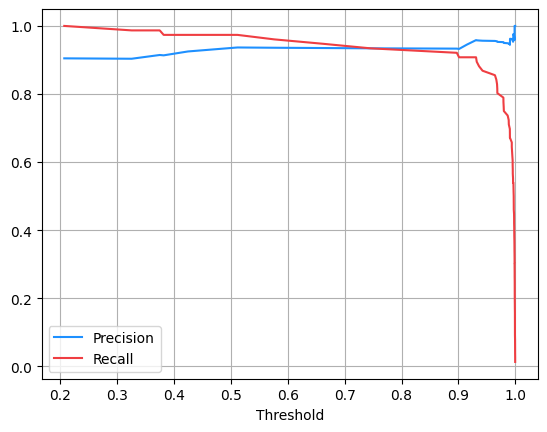

In [133]:
# ROC curve to plot precision and recall against thresholds 0-1 to visualize the trade-off

prec, recall, thresholds = precision_recall_curve(y_test, y_proba_grid)
plt.plot(thresholds, prec[:-1], label='Precision', color = 'dodgerblue')
plt.plot(thresholds, recall[:-1], label='Recall', color = dodgerred)
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.show()

## Stage 5: Building Run Expectancy Matrix

In [134]:
# function to get the cumulative runs for both the home and away team for each inning

def get_cumulative_runs(runs_by_inning):

    cumu_runs_by_inning = list()
    home_runs = 0
    away_runs = 0
    for inn in runs_by_inning:
        if 'runs' in inn['home']:
            home_runs += inn['home']['runs']
        if 'runs' in inn['away']:
            away_runs += inn['away']['runs']
        
        inn_dict = dict()
        inn_dict['inning'] = inn['num']
        inn_dict['home'] = home_runs
        inn_dict['away'] = away_runs

        cumu_runs_by_inning.append(inn_dict)
    
    return cumu_runs_by_inning

In [135]:
# function to calculate run expectancy matrix for a given time frame and pro baseball level
# levels are as follows:
#
# Majors:       1
# Triple-A:     11
# Double-A:     12
# High-A:       13 (Class A Advanced)
# Low-A:        14 (Class A)
# Rookie:       16

def get_re24(start_date, end_date, level):

    re24 = {
        '000': {0:[], 1:[], 2:[]},
        '100': {0:[], 1:[], 2:[]},
        '010': {0:[], 1:[], 2:[]},
        '001': {0:[], 1:[], 2:[]},
        '110': {0:[], 1:[], 2:[]},
        '101': {0:[], 1:[], 2:[]},
        '011': {0:[], 1:[], 2:[]},
        '111': {0:[], 1:[], 2:[]},
    }

    home_away_map = {'top': 'away', 'bottom':'home'}

    dates_url = f'https://statsapi.mlb.com/api/v1/schedule?sportId={level}&startDate={start_date}&endDate={end_date}'
    schedule_data = requests.get(dates_url).json()

    dates = schedule_data['dates']
    for date_idx in range(len(dates)):
        games = dates[date_idx]['games']
        for game_idx in range(len(games)):
            game_id = games[game_idx]['gamePk']

            game_url = f'https://statsapi.mlb.com/api/v1.1/game/{game_id}/feed/live'
            game_data = requests.get(game_url).json()
            all_plays = game_data['liveData']['plays']['allPlays']

            cumu_runs_by_inning = get_cumulative_runs(game_data['liveData']['linescore']['innings'])

            for i in range(1, len(all_plays)):
                outs = all_plays[i]['playEvents'][0]['count']['outs']

                prev_bases = all_plays[i-1]['matchup']
                fb = int('postOnFirst' in prev_bases)
                sb = int('postOnSecond' in prev_bases)
                tb = int('postOnThird' in prev_bases)
                bases = f'{fb}{sb}{tb}'

                inning = all_plays[i]['about']['inning']
                half_inning = all_plays[i]['about']['halfInning']
                home_away = home_away_map[half_inning]

                runs_eoi = cumu_runs_by_inning[inning-1][home_away]
                runs_start = all_plays[i-1]['result'][f'{home_away}Score']
                runs_added = runs_eoi - runs_start

                re24[bases][outs].append(runs_added)
    
    return {bases: {outs: mean(re24[bases][outs]) for outs in re24[bases]} for bases in re24}

In [136]:
# re24 = get_re24('2018-03-31','2018-05-31', 14)

In [137]:
# the call above took roughly 15 minutes to calculate and it was only for 2 months worth of games, so I hard coded my results here

re24 = {
    '000': {0: 0.5270317896665961, 1: 0.27510704554301285, 2: 0.10222788033099936},
    '100': {0: 0.934899157518509, 1: 0.5398812049215104, 2: 0.23293607800650054},
    '010': {0: 1.110204081632653, 1: 0.6598523566155593, 2: 0.3257343270495397},
    '001': {0: 1.61, 1: 0.9435825105782792, 2: 0.35051546391752575},
    '110': {0: 1.674852652259332, 1: 0.9988262910798122, 2: 0.46635850025680536},
    '101': {0: 1.841225626740947, 1: 1.0851900393184797, 2: 0.582741116751269},
    '011': {0: 1.9947643979057592, 1: 1.3967611336032388, 2: 0.6395348837209303},
    '111': {0: 2.857142857142857, 1: 1.7307692307692308, 2: 0.8991060025542784}
}

In [168]:
# # RE24 in Matrix Format

# rem = pd.DataFrame(re24).T.reset_index()
# rem.columns = ['Base State', '0 Outs', '1 Outs', '2 Outs']
# rem = rem.set_index('Base State').round(3)
# md = rem.to_markdown()
# # print(md)
# rem

|   Base State |   0 Outs |   1 Outs |   2 Outs |
|-------------:|---------:|---------:|---------:|
|          000 |    0.527 |    0.275 |    0.102 |
|          100 |    0.935 |    0.54  |    0.233 |
|          010 |    1.11  |    0.66  |    0.326 |
|          001 |    1.61  |    0.944 |    0.351 |
|          110 |    1.675 |    0.999 |    0.466 |
|          101 |    1.841 |    1.085 |    0.583 |
|          011 |    1.995 |    1.397 |    0.64  |
|          111 |    2.857 |    1.731 |    0.899 |

## Stage 6: Adding RE Values to Calculate Breakeven Probability

In [139]:
def calculate_breakeven_prob(base_state, outs, runner, re24):
    stay_runs_gained = 0

    if base_state == '010':
        out_base_state = '100'
        out_runs_gained = 0

        safe_base_state = '101'
        safe_runs_gained = 0

    if base_state == '011':
        if runner == '2B':
            out_base_state = '100'
            out_runs_gained = 1

            safe_base_state = '101'
            safe_runs_gained = 1

            stay_runs_gained = 1

        else:
            out_base_state = '101'
            out_runs_gained = 0

            safe_base_state = '110'
            safe_runs_gained = 1

    if base_state == '001':
        out_base_state = '100'
        out_runs_gained = 0

        safe_base_state = '100'
        safe_runs_gained = 1        

    if base_state == '101':
        out_base_state = '110'
        out_runs_gained = 0

        safe_base_state = '110'
        safe_runs_gained = 1

    stay_re = re24[base_state][outs+1] + stay_runs_gained
    out_re = re24[out_base_state][outs+1] + out_runs_gained
    safe_re = re24[safe_base_state][outs] + safe_runs_gained

    return round((stay_re - out_re) / (safe_re - out_re),4)
    

In [140]:
# adding the breakeven probability to each play

poi_expanded_final['breakeven_prob'] = poi_expanded_final.apply(lambda x: calculate_breakeven_prob(x['base_state'],x['outs'],x['runner'],re24), axis = 1)

In [141]:
# determining if it was worth the risk for the player to attempt to advance

poi_expanded_final['should_att'] = poi_expanded_final['safe_prob'] > poi_expanded_final['breakeven_prob']

# adding if they did advance to compare their decision to the mathematically correct one
poi_expanded_final['adv_att'] = poi_expanded['adv_att'].astype(bool).copy()

# adding game and play ids so games can be animated
poi_expanded_final['game_str'] = poi_expanded['game_str'].copy()
poi_expanded_final['play_id'] = poi_expanded['play_id'].copy()

# add safe value
poi_expanded_final['safe'] = poi_expanded['safe'].copy()

In [217]:
# poi_expanded with an added column for the game, play id
pef_team = plays_summary_filled[['game_str','play_id','batter']+runner_cols].merge(poi_expanded_final, on = ['game_str','play_id'])

# classifying baserunner's decision making
pef_team.loc[(~pef_team['should_att']) & (pef_team['adv_att']), 'choice'] = 'Aggressive'
pef_team.loc[(pef_team['should_att']) & (~pef_team['adv_att']), 'choice'] = 'Passive'
pef_team['choice'] = pef_team['choice'].fillna('Smart')

# adding team
pef_team['team'] = pef_team['batter'].str[:3]

In [221]:
# percentage of good choice plays for only known teams

teams = readDataSubset('rosters').to_table().to_pandas().columns
pef_team[pef_team['adv_att']].groupby('team')[['choice']].agg(lambda x: sum(x=='Smart')/len(x)).loc[teams]

,choice
DYE,1.000000
OXG,0.666667
QEA,0.956522
RZQ,0.888889
YJD,0.946429


In [222]:
spray_chart = pef_team[['fielder_pos_x','fielder_pos_y','exit_velo', 'exit_velo_cats']].copy()
spray_chart['exit_velo'] = spray_chart['exit_velo'].transform(lambda x: (x-x.min()) / (x.max()-x.min())) * 6 + 1

In [223]:
import matplotlib.patches as mpatches

In [224]:
# # plot showing where decision making tendencies change and how they can be affected by ball's exit velo

# line_colors = ['dodgerblue', 'maroon']
# choice_colors = ['limegreen', dodgerred, '#3b82f6']

# choice_map = dict(zip(['good', 'aggressive', 'passive'], choice_colors))

# spray_chart = pef_team[['fielder_pos_x','fielder_pos_y','exit_velo', 'hard_hit']].copy()
# hard_hit_map = dict(zip([True, False], line_colors))
# spray_chart['hard_hit'] = spray_chart['hard_hit'].map(hard_hit_map)

# fig, ax = plt.subplots(figsize=(9,10))

# ax.axhline(0, color='black', linewidth=2)
# ax.axvline(0, color='black', linewidth=2)

# legend_handles_choice = [mpatches.Patch(color=color, label=label.title()) for label, color in choice_map.items()]
# legend1 = ax.legend(handles=legend_handles_choice, title='Runner Choice', loc='upper left')

# legend_handles_hh = [
#     mpatches.Patch(color=line_colors[0], label='Hard Hit'),
#     mpatches.Patch(color=line_colors[1], label='Not Hard Hit')
# ]
# legend2 = ax.legend(handles=legend_handles_hh, title='Batted Ball Type', loc='upper right')

# ax.add_artist(legend1)

# ax.scatter(
#     x=pef_team['fielder_pos_x'],
#     y=pef_team['fielder_pos_y'],
#     c=pef_team['choice'].map(choice_map),
# )

# # for row in range(len(spray_chart)):
# #     x = spray_chart.loc[row, 'fielder_pos_x']
# #     y = spray_chart.loc[row, 'fielder_pos_y']
# #     color = spray_chart.loc[row, 'hard_hit']

# #     ax.plot(
# #         [0, x],
# #         [0, y],
# #         linewidth=2,
# #         alpha=0.2,
# #         color=color,
# #     )

# ax.set_xlabel('Field X Position (ft)')
# ax.set_ylabel('Field Y Position (ft)')
# ax.set_title('Fielder Position and Ball Path with Exit Velo & Runner Decision')
# ax.grid(True)

# plt.show()


## Stage 6: Data Visualization

In [225]:
from sportypy.surfaces import MiLBField
from matplotlib.patches import Rectangle

In [226]:
choice_colors = ['limegreen', dodgerred, '#3b82f6']
choice_map = dict(zip(['Smart', 'Aggressive', 'Passive'], choice_colors))

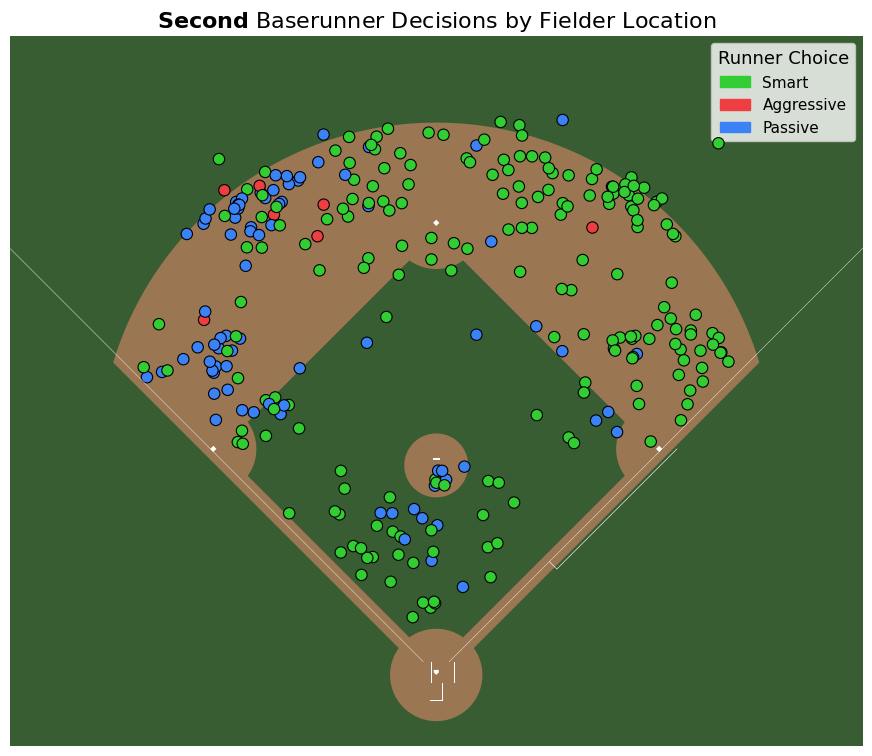

In [237]:
field = MiLBField()

fig, ax = plt.subplots(figsize=(11,11))
ax.set_facecolor('black')

field.draw(ax=ax)

runner_df = pef_team[pef_team['runner']=='2B']
x_coords = runner_df['fielder_pos_x']
y_coords = runner_df['fielder_pos_y']
colors = runner_df['choice'].map(choice_map)

ax.scatter(
    x_coords,
    y_coords,
    c=colors,
    s=67,
    edgecolor='black',
    linewidth=.8,
    # alpha=0.8,
    zorder=15,
    
)


ax.add_patch(Rectangle(
    xy=(-250, -50),
    width=500,
    height=500,
    facecolor="#395d33",
))

ax.set_title(r"$\bf{Second}$ Baserunner Decisions by Fielder Location", fontsize=16)
ax.set_xlim(-120, 120)
ax.set_ylim(-20, 180)
# ax.set_aspect('equal')
ax.grid(True)

legend_handles = [
    mpatches.Patch(color=color, label=label.title()) 
    for label, color in choice_map.items()
]

ax.legend(handles=legend_handles, title="Runner Choice", loc="upper right",title_fontsize=13,fontsize=11)

plt.show()


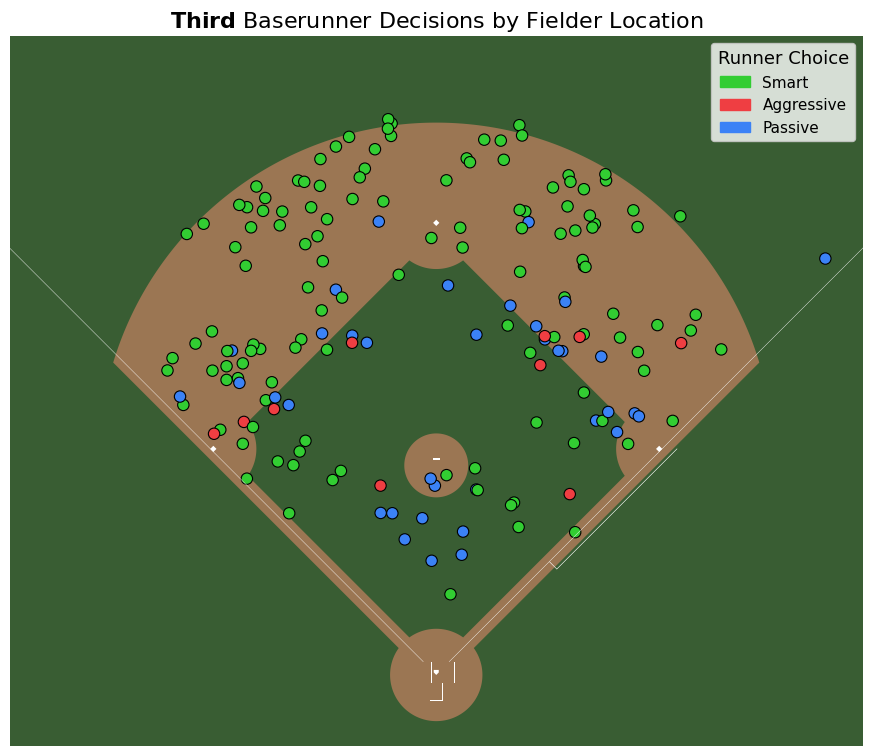

In [238]:
field = MiLBField()

fig, ax = plt.subplots(figsize=(11,11))
ax.set_facecolor('black')

field.draw(ax=ax)

runner_df = pef_team[pef_team['runner']=='3B']
x_coords = runner_df['fielder_pos_x']
y_coords = runner_df['fielder_pos_y']
colors = runner_df['choice'].map(choice_map)

ax.scatter(
    x_coords,
    y_coords,
    c=colors,
    s=67,
    edgecolor='black',
    linewidth=.8,
    # alpha=0.8,
    zorder=15,
    
)


ax.add_patch(Rectangle(
    xy=(-250, -50),
    width=500,
    height=500,
    facecolor="#395d33",
))

ax.set_title(r"$\bf{Third}$ Baserunner Decisions by Fielder Location", fontsize=16)
ax.set_xlim(-120, 120)
ax.set_ylim(-20, 180)
# ax.set_aspect('equal')
ax.grid(True)

legend_handles = [
    mpatches.Patch(color=color, label=label.title()) 
    for label, color in choice_map.items()
]

ax.legend(handles=legend_handles, title="Runner Choice", loc="upper right",title_fontsize=13,fontsize=11)

plt.show()


In [202]:
import seaborn as sns

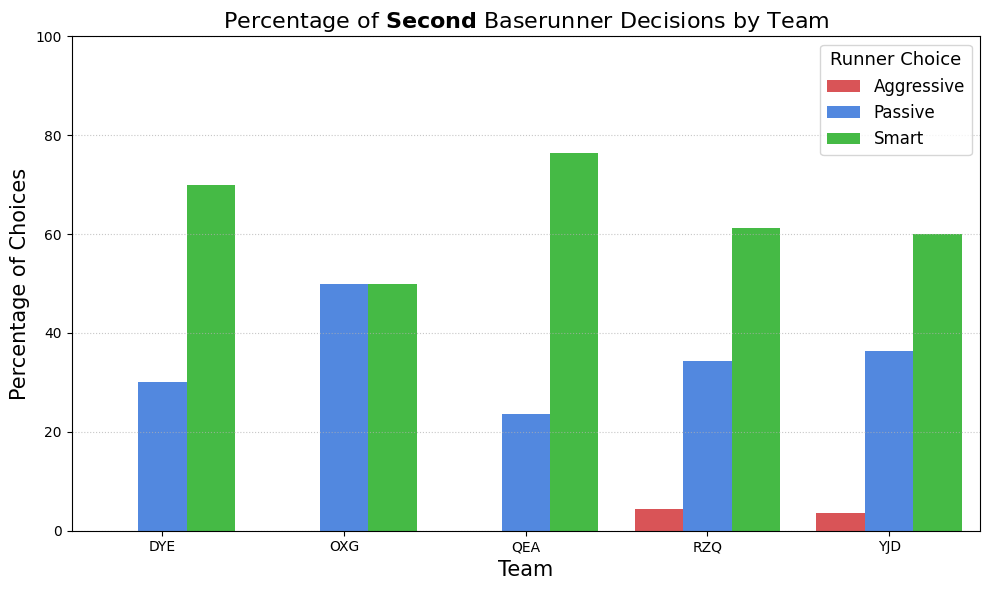

In [262]:
# Calculate proportions of each 2B runner choice by team

pef_team_2b = pef_team[pef_team['runner']=='2B']
choice_props = pef_team_2b[pef_team_2b['team'].isin(teams)].groupby('team')['choice'].apply(lambda x: x.value_counts() / len(x)).unstack(fill_value = 0).reset_index()

choice_props_melted = choice_props.melt(id_vars='team', var_name='choice', value_name='proportion')
choice_props_melted['proportion'] *= 100


plt.figure(figsize=(10, 6))
sns.barplot(data=choice_props_melted, x='team', y='proportion', hue='choice', palette=choice_map)
plt.title(r'Percentage of $\bf{Second}$ Baserunner Decisions by Team', fontsize=16)
plt.ylabel('Percentage of Choices',fontsize=15)
plt.xlabel('Team',fontsize=15)
plt.legend(title='Runner Choice',title_fontsize=13,fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


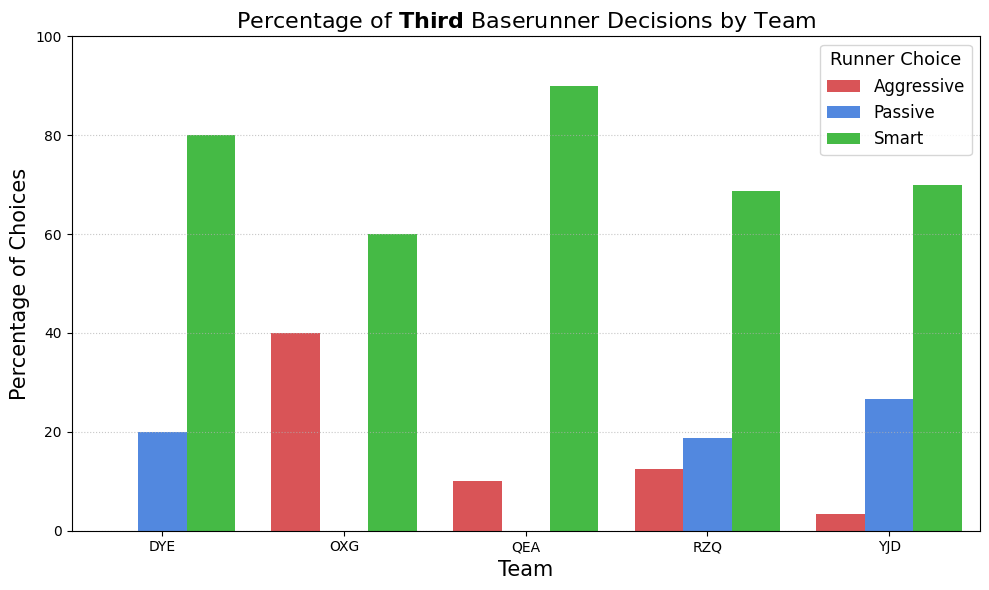

In [263]:
# Calculate proportions of each 2B runner choice by team

pef_team_3b = pef_team[pef_team['runner']=='3B']
choice_props = pef_team_3b[pef_team_3b['team'].isin(teams)].groupby('team')['choice'].apply(lambda x: x.value_counts() / len(x)).unstack(fill_value = 0).reset_index()

choice_props_melted = choice_props.melt(id_vars='team', var_name='choice', value_name='proportion')
choice_props_melted['proportion'] *= 100


plt.figure(figsize=(10, 6))
sns.barplot(data=choice_props_melted, x='team', y='proportion', hue='choice', palette=choice_map)
plt.title(r'Percentage of $\bf{Third}$ Baserunner Decisions by Team', fontsize=16)
plt.ylabel('Percentage of Choices',fontsize=15)
plt.xlabel('Team',fontsize=15)
plt.legend(title='Runner Choice',title_fontsize=13,fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


In [250]:
# get data where player's name is available and separate baserunner data

runners_2b = pef_team[((pef_team['second_baserunner'].apply(lambda x: True if isinstance(x,str) and re.match(r'[A-Z]{3}-[0-9]', x) else False))) & (pef_team['runner']=='2B') & pef_team['team'].isin(teams)]
runners_3b = pef_team[((pef_team['third_baserunner'].apply(lambda x: True if isinstance(x,str) and re.match(r'[A-Z]{3}-[0-9]', x) else False))) & (pef_team['runner']=='3B') & pef_team['team'].isin(teams)]

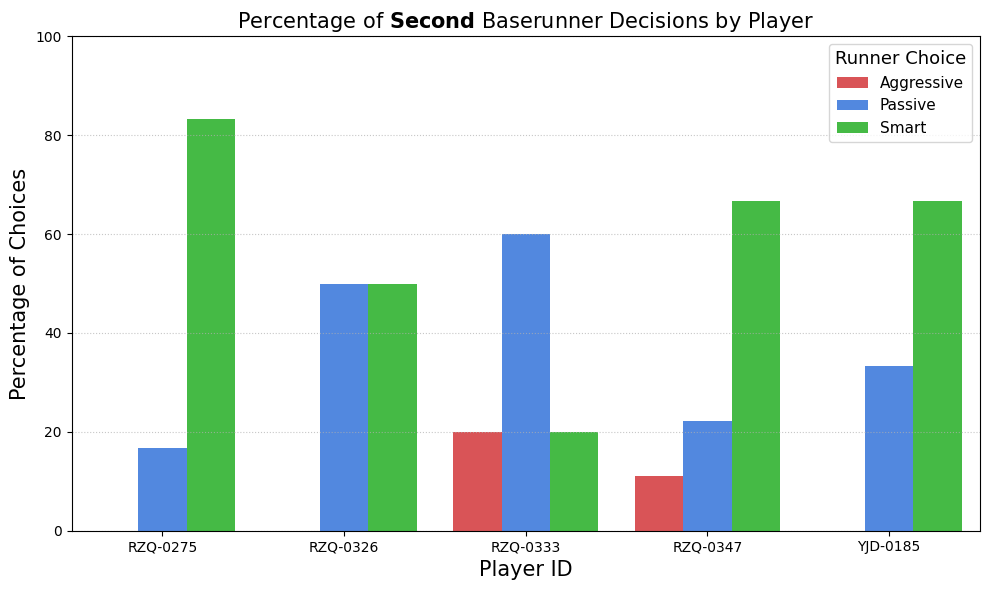

In [265]:
# Calculate proportions of 2B runner choices for the 5 most seen players

most_seen = runners_2b['second_baserunner'].value_counts().head(5).index
choice_props = runners_2b.groupby('second_baserunner')['choice'].apply(lambda x: x.value_counts()/len(x)).unstack(fill_value=0).reset_index()
choice_props = choice_props[choice_props['second_baserunner'].isin(most_seen)]

choice_props_melted = choice_props.melt(id_vars='second_baserunner', var_name='choice', value_name='proportion')
choice_props_melted['proportion'] *= 100

plt.figure(figsize=(10, 6))
sns.barplot(data=choice_props_melted, x='second_baserunner', y='proportion', hue='choice', palette=choice_map)
plt.title(r'Percentage of $\bf{Second}$ Baserunner Decisions by Player', fontsize = 15)
plt.ylabel('Percentage of Choices',fontsize=15)
plt.xlabel('Player ID',fontsize=15)
plt.legend(title='Runner Choice',title_fontsize=13,fontsize=11)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


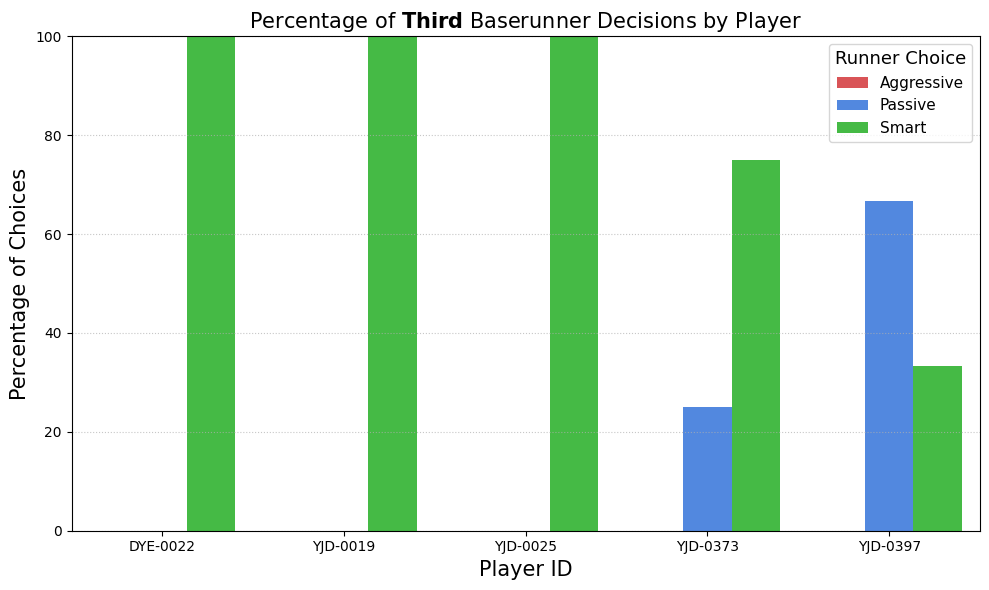

In [266]:
# Calculate proportions of 3B runner choices for the 5 most seen players

most_seen = runners_3b['third_baserunner'].value_counts().head(5).index
choice_props = runners_3b.groupby('third_baserunner')['choice'].apply(lambda x: x.value_counts()/len(x)).unstack(fill_value=0).reset_index()
choice_props = choice_props[choice_props['third_baserunner'].isin(most_seen)]

choice_props_melted = choice_props.melt(id_vars='third_baserunner', var_name='choice', value_name='proportion')
choice_props_melted['proportion'] *= 100


plt.figure(figsize=(10, 6))
sns.barplot(data=choice_props_melted, x='third_baserunner', y='proportion', hue='choice', palette=choice_map)
plt.title(r'Percentage of $\bf{Third}$ Baserunner Decisions by Player', fontsize = 15)
plt.ylabel('Percentage of Choices',fontsize=15)
plt.xlabel('Player ID',fontsize=15)
plt.legend(title='Runner Choice',title_fontsize=13,fontsize=11)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


In [157]:
# # download data results
# pef_team.to_csv('results.csv',index=False)